PROOJECT PhaseFoundry: A “foundry” for phase-field, CALPHAD, and ML interatomic potentials 
====================================

Description:
-------------
This notebook implements a thermodynamically consistent phase-field model for simulating spinodal decomposition and microstructural evolution in multicomponent alloy systems. The framework is coupled with pyCALPHAD to incorporate CALPHAD-based free energies directly from thermodynamic databases, enabling accurate thermodynamic representation. First-order derivatives of the free energy are computed using a semi-analytical approach to improve numerical precision. The thermodynamic descriptions are derived from databases constructed using machine learning–based interatomic potentials, allowing flexible and data-driven thermodynamic integration.

Features:
- Multicomponent Cahn–Hilliard equation using pseudo-spectral method
- Periodic boundary conditions
- Supports both idealized and CALPHAD-based free energy descriptions

Contributors:
-------------
- Phase-field Models: Vahid Attari, Ph.D., TAMU (attari.v@tamu.edu)
  - Semi-implicit solver for Cahn-Hillaird Model coupled to semi-analytic derivatives of thermodynamic properties
- pyCALPHAD model: Courtney Kunselman, TAMU (cjkunselman18@tamu.edu)
  - semi-analytic derivatives of thermodynamic potentials
    
Model Name:
------------
CALPHAD-Reinforced Microstructure Modeling using Cahn–Hilliard Phase-Field Model

License:
---------
MIT License (feel free to reuse and modify with attribution)

In [1]:
!pip install plotly
!pip install tqdm
!pip install umap-learn

In [2]:
import numpy as np
from numpy.fft import fftn, ifftn, fftfreq
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2
from tqdm import tqdm
import os
print(os.getcwd())

/Users/attari.v/Documents/PROJECTS/pycalphad/PhaseFoundry


# Binary Solver
- Using polynomial energy model

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1971/2000 [00:04<00:00, 518.10it/s]

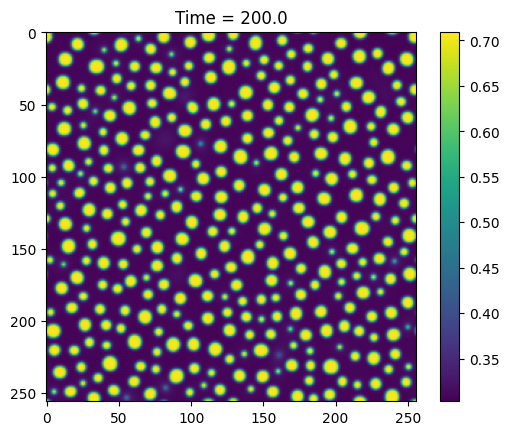

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 481.49it/s]


In [3]:
# ==== Material Parameters ====
X11 = 0.4        # Initial composition
Kappa_c = 0.1    # Gradient energy coefficient
M = 1.0          # Mobility
rho_s = 5.0      # Free energy prefactor

# ==== Grid Setup ====
Lx = 200
N = 256
h = Lx / (N - 1)
x = np.linspace(0, Lx, N)
y = x.copy()
xx, yy = np.meshgrid(x, y)

# MATLAB-style frequency vector: [0:N/2-1 0 -N/2+1:-1]
k = np.concatenate((
    np.arange(0, N//2),   # 0 to 127
    [0],                  # Center value (same as in MATLAB)
    np.arange(-N//2+1, 0) # -127 to -1
))

# ==== Fourier Space Setup ====
g = 2 * np.pi / Lx
kx = g * 1j * k
ky = g * 1j * k
kx, ky = np.meshgrid(kx, ky)
k2 = kx**2 + ky**2

# ==== Initial Condition ====
np.random.seed(0)
c = X11 + 0.01 * (np.random.rand(N, N) - 0.5)

# ==== Time Setup ====
dt = 0.1
tmax = 200
max_iter = int(tmax / dt)
plot_indices = np.linspace(0, max_iter, 20, dtype=int)

# ==== Create Output Folder ====
if os.path.exists("microstructure-binary"):
    os.system("rm -r microstructure-binary")
os.makedirs("microstructure-binary", exist_ok=True)

# ==== Free Energy Derivative ====
def dFdc(c, rho_s):
    c_a = 0.3;
    c_b = 0.7;    
    return -2 * rho_s * (c-c_a) * (c-c_b) * (c_a+c_b-2*c)  # Double-well derivative

# ==== Data Storage ====
field, time_arr, Y1, Y2, Y3, Y4 = [], [], [], [], [], []

# ==== Simulation Loop ====
for n in tqdm(range(1, max_iter + 1)):
    mu = dFdc(c, rho_s)
    mu_hat = fft2(mu)
    c_hat = fft2(c)
    num = c_hat + M * dt * k2 * mu_hat
    denom = 1 + 2 * M * Kappa_c * dt * k2**2
    c = np.real(ifft2(num / denom))

    if n == 1 or n in plot_indices or n == max_iter:
        field.append(c.copy())
        time_arr.append(n * dt)
        Y1.append(np.mean(c > X11))                       # Crude vol. frac
        Y2.append(np.mean(np.abs(np.gradient(c)[0])))     # Crude length scale
        Y3.append(np.max(c))                              # Max composition
        Y4.append(np.min(c))                              # Min composition

        plt.imshow(c, cmap='viridis')
        plt.title(f'Time = {n*dt:.1f}')
        plt.colorbar()
        plt.savefig(f'microstructure-binary/comp_time_frame{n}.jpg')
        if n == max_iter:
            plt.show()        
        plt.close()        

# ==== Save Simulation Data ====
np.savez("sim_result.npz",
         init_conditions={'X11': X11, 'Lx': Lx, 'Ly': Lx, 'mesh_size': N, 'dx': h, 'dt': dt},
         evolution={'field_order_parameter': field, 'time': time_arr},
         metrics={'vol_frac': Y1, 'char_length_scale': Y2, 'max_comp': Y3, 'min_comp': Y4})

# Ternary Solver
## Polynomial Model

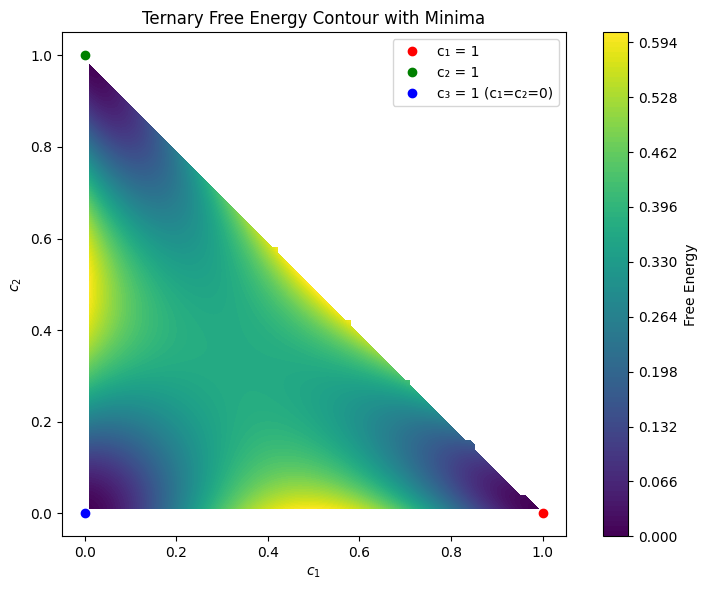

In [4]:
import numpy as np
import matplotlib.pyplot as plt
    
# Free energy function
def fchem_three_well(c1, c2, rho_s=10):
    c3 = 1.0 - c1 - c2
    return rho_s * (c1**2 * c2**2 + c2**2 * c3**2 + c3**2 * c1**2)

# Composition grid
delta = 0.01
c1_vals = np.arange(0.01, 0.99 + delta, delta)
c2_vals = np.arange(0.01, 0.99 + delta, delta)
X, Y = np.meshgrid(c1_vals, c2_vals)
Z = 1.0 - X - Y

# Mask valid region (c3 > 0)
F = np.full_like(X, np.nan)
mask = Z > 0
F[mask] = fchem_three_well(X[mask], Y[mask])

# Plot contour
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(X, Y, F, levels=100, cmap='viridis')
plt.colorbar(contour, label='Free Energy')

# Mark ideal minima: (1,0,0), (0,1,0), (0,0,1)
ax.plot(1, 0, 'ro', label='c₁ = 1')
ax.plot(0, 1, 'go', label='c₂ = 1')
ax.plot(0, 0, 'bo', label='c₃ = 1 (c₁=c₂=0)')

# Format
ax.set_xlabel('$c_1$')
ax.set_ylabel('$c_2$')
ax.set_title('Ternary Free Energy Contour with Minima')
ax.legend()
ax.set_aspect('equal')
plt.tight_layout()
plt.savefig('energy_landscape_ternary.jpg',dpi=300)
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████▌| 1991/2000 [00:10<00:00, 231.13it/s]

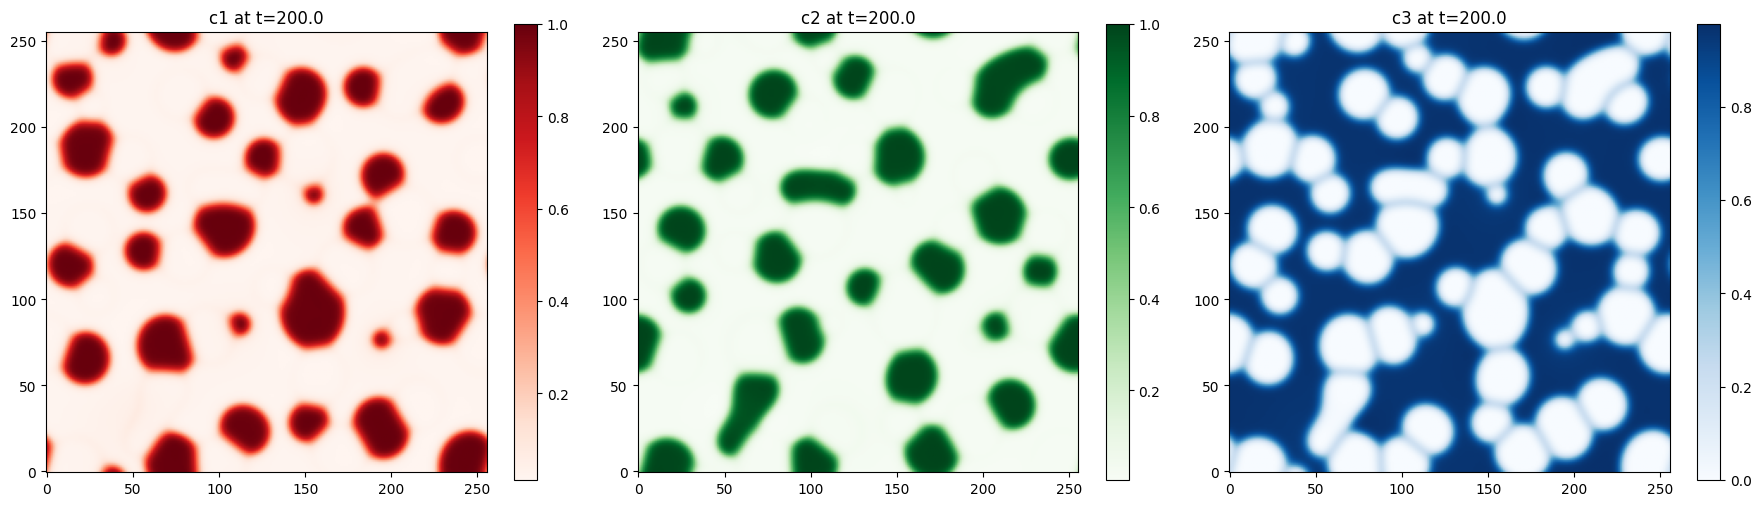

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 188.07it/s]


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2
import os
from tqdm import tqdm

# ==== Simulation Parameters ====
Kappa_c = 20.0    # Gradient energy coefficient
M = 1.0          # Mobility
rho_s = 20.0     # Free energy prefactor

# ==== Grid Setup ====
Lx = 200
N = 256
h = Lx / (N - 1)
x = np.linspace(0, Lx, N)
y = x.copy()
xx, yy = np.meshgrid(x, y)

# ==== Spectral k-vectors ====
k = np.concatenate((np.arange(0, N//2), [0], np.arange(-N//2+1, 0)))
g = 2 * np.pi / Lx
kx = g * 1j * k
ky = g * 1j * k
kx, ky = np.meshgrid(kx, ky)
k2 = kx**2 + ky**2

# ==== Initial Conditions ====
np.random.seed(0)
c1 = 0.25 + 0.01 * (np.random.rand(N, N) - 0.5)
c2 = 0.25 + 0.01 * (np.random.rand(N, N) - 0.5)
c3 = 1.0 - c1 - c2

# ==== Time Setup ====
dt = 0.1
tmax = 200
max_iter = int(tmax / dt)
plot_indices = np.linspace(0, max_iter, 20, dtype=int)

# ==== Output Directory ====
if os.path.exists("microstructure-ternary"):
    os.system("rm -r microstructure-ternary")
os.makedirs("microstructure-ternary", exist_ok=True)

# ==== Free Energy Function ====
def fchem_three_well(c1, c2, rho_s=20):
    c3 = 1.0 - c1 - c2
    return rho_s * (c1**2 * c2**2 + c2**2 * c3**2 + c3**2 * c1**2)

# ==== Chemical Potential Derivatives ====
def dfdc1(c1, c2, rho_s):
    c3 = 1.0 - c1 - c2
    return rho_s * (2*c1*c2**2 + 2*c1*c3**2 - 2*c1**2*c3)

def dfdc2(c1, c2, rho_s):
    c3 = 1.0 - c1 - c2
    return rho_s * (2*c2*c1**2 + 2*c2*c3**2 - 2*c2**2*c3)

# ==== Simulation Loop ====
for n in tqdm(range(1, max_iter + 1)):
    mu1 = dfdc1(c1, c2, rho_s)
    mu2 = dfdc2(c1, c2, rho_s)

    mu1_hat = fft2(mu1)
    mu2_hat = fft2(mu2)
    c1_hat = fft2(c1)
    c2_hat = fft2(c2)

    num1 = c1_hat + M * dt * k2 * mu1_hat
    num2 = c2_hat + M * dt * k2 * mu2_hat
    denom = 1 + 2 * M * Kappa_c * dt * k2**2

    c1 = np.real(ifft2(num1 / denom))
    c2 = np.real(ifft2(num2 / denom))
    c3 = 1.0 - c1 - c2

    # Clip to physical range
    c1 = np.clip(c1, 0.0, 1.0)
    c2 = np.clip(c2, 0.0, 1.0)
    c3 = np.clip(c3, 0.0, 1.0)

    # Plot results
    if n == 1 or n in plot_indices or n == max_iter:
        plt.figure(figsize=(18, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(c1, cmap='Reds', origin='lower')
        plt.title(f'c1 at t={n*dt:.1f}')
        plt.colorbar()

        plt.subplot(1, 3, 2)
        plt.imshow(c2, cmap='Greens', origin='lower')
        plt.title(f'c2 at t={n*dt:.1f}')
        plt.colorbar()

        plt.subplot(1, 3, 3)
        plt.imshow(c3, cmap='Blues', origin='lower')
        plt.title(f'c3 at t={n*dt:.1f}')
        plt.colorbar()

        plt.tight_layout()
        plt.savefig(f'microstructure-ternary/ternary_frame_{n}.jpg')
        if n == max_iter:
            plt.show()
        plt.close()

# Quaternary

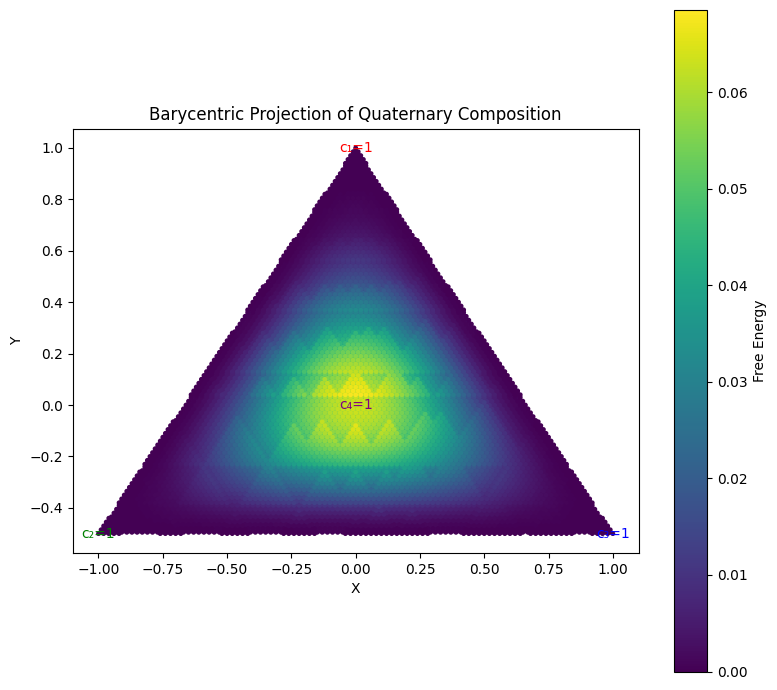

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Free energy model 1
def fchem_quaternary(c1, c2, c3, c4, rho_s=20):
    return rho_s * (
        c1**2 * c2**2 + c1**2 * c3**2 + c1**2 * c4**2 +
        c2**2 * c3**2 + c2**2 * c4**2 + c3**2 * c4**2
    )
    
# Free energy model 2
def fchem_four_well(c1, c2, c3, c4, rho_s=50):
    f1 = (c1 - 1)**2 * c2**2 * c3**2 * c4**2
    f2 = (c2 - 1)**2 * c1**2 * c3**2 * c4**2
    f3 = (c3 - 1)**2 * c1**2 * c2**2 * c4**2
    f4 = (c4 - 1)**2 * c1**2 * c2**2 * c3**2
    return rho_s * (f1 + f2 + f3 + f4)

# Generate valid quaternary compositions
delta = 0.01
comps = []
for c1 in np.arange(0, 1+delta, delta):
    for c2 in np.arange(0, 1-c1+delta, delta):
        for c3 in np.arange(0, 1-c1-c2+delta, delta):
            c4 = 1.0 - c1 - c2 - c3
            if 0 <= c4 <= 1:
                comps.append([c1, c2, c3, c4])
comps = np.array(comps)
c1, c2, c3, c4 = comps[:,0], comps[:,1], comps[:,2], comps[:,3]

# Compute free energy
fchem_four_well
#F = fchem_quaternary(c1, c2, c3, c4)
F = fchem_four_well(c1, c2, c3, c4)

# Define 4 2D corners for a diamond-shaped quad
v1 = np.array([0.0, 1.0])   # c1 = 1 (top)
v2 = np.array([-1.0, -0.5]) # c2 = 1 (bottom-left)
v3 = np.array([1.0, -0.5])  # c3 = 1 (bottom-right)
v4 = np.array([0.0, 0.0])   # c4 = 1 (center-bottom)

# Project to 2D using barycentric blend of vertices
XY = (np.outer(c1, v1) +
      np.outer(c2, v2) +
      np.outer(c3, v3) +
      np.outer(c4, v4))
X, Y = XY[:,0], XY[:,1]

# Plot
fig, ax = plt.subplots(figsize=(8, 7))
sc = ax.scatter(X, Y, c=F, cmap='viridis', s=12, edgecolors='none')
plt.colorbar(sc, label="Free Energy")

# Label corners
ax.text(*v1, "c₁=1", color='red', ha='center', va='center')
ax.text(*v2, "c₂=1", color='green', ha='center', va='center')
ax.text(*v3, "c₃=1", color='blue', ha='center', va='center')
ax.text(*v4, "c₄=1", color='purple', ha='center', va='center')

ax.set_title("Barycentric Projection of Quaternary Composition")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 3991/4000 [00:23<00:00, 199.90it/s]

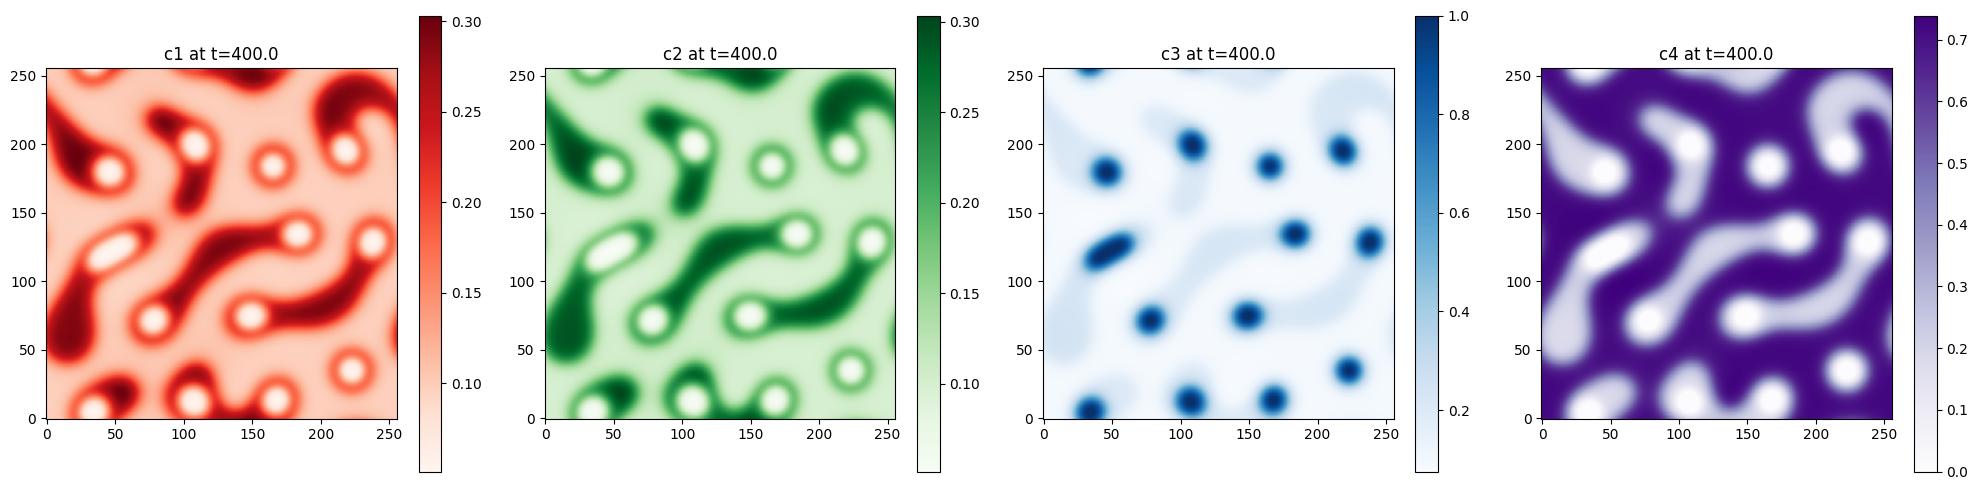

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:24<00:00, 163.98it/s]


In [7]:
# ==== Simulation Parameters ====
Kappa_c = 20.0
M = 1.0
rho_s = 20.0

# ==== Grid Setup ====
Lx = 200
N = 256
h = Lx / (N - 1)
x = np.linspace(0, Lx, N)
y = x.copy()
xx, yy = np.meshgrid(x, y)

# ==== Spectral k-vectors ====
k = np.concatenate((np.arange(0, N//2), [0], np.arange(-N//2+1, 0)))
g = 2 * np.pi / Lx
kx = g * 1j * k
ky = g * 1j * k
kx, ky = np.meshgrid(kx, ky)
k2 = kx**2 + ky**2

# ==== Initial Conditions ====
np.random.seed(0)
c1 = 0.15 + 0.01 * (np.random.rand(N, N) - 0.5)
c2 = 0.15 + 0.01 * (np.random.rand(N, N) - 0.5)
c3 = 0.25 + 0.01 * (np.random.rand(N, N) - 0.5)
c4 = 1.0 - c1 - c2 - c3

# ==== Time Setup ====
dt = 0.1
tmax = 400
max_iter = int(tmax / dt)
plot_indices = np.linspace(0, max_iter, 20, dtype=int)

# ==== Output Directory ====
if os.path.exists("microstructure-quaternary"):
    os.system("rm -r microstructure-quaternary")
os.makedirs("microstructure-quaternary", exist_ok=True)

# ==== Free Energy Function ====
def fchem_quaternary(c1, c2, c3, c4, rho_s=20):
    return rho_s * (
        c1**2 * c2**2 + c1**2 * c3**2 + c1**2 * c4**2 +
        c2**2 * c3**2 + c2**2 * c4**2 + c3**2 * c4**2
    )

def fchem_four_well(c1, c2, c3, c4, rho_s=20):
    f1 = (c1 - 1)**2 * c2**2 * c3**2 * c4**2
    f2 = (c2 - 1)**2 * c1**2 * c3**2 * c4**2
    f3 = (c3 - 1)**2 * c1**2 * c2**2 * c4**2
    f4 = (c4 - 1)**2 * c1**2 * c2**2 * c3**2
    return rho_s * (f1 + f2 + f3 + f4)
    

# ==== Chemical Potential Derivatives ====
def dfdc1(c1, c2, c3, c4, rho_s):
    return rho_s * (2 * c1 * c2**2 + 2 * c1 * c3**2 + 2 * c1 * c4**2)

def dfdc2(c1, c2, c3, c4, rho_s):
    return rho_s * (2 * c2 * c1**2 + 2 * c2 * c3**2 + 2 * c2 * c4**2)

def dfdc3(c1, c2, c3, c4, rho_s):
    return rho_s * (2 * c3 * c1**2 + 2 * c3 * c2**2 + 2 * c3 * c4**2)

# ==== Simulation Loop ====
for n in tqdm(range(1, max_iter + 1)):
    c4 = 1.0 - c1 - c2 - c3

    mu1 = dfdc1(c1, c2, c3, c4, rho_s)
    mu2 = dfdc2(c1, c2, c3, c4, rho_s)
    mu3 = dfdc3(c1, c2, c3, c4, rho_s)

    mu1_hat = fft2(mu1)
    mu2_hat = fft2(mu2)
    mu3_hat = fft2(mu3)

    c1_hat = fft2(c1)
    c2_hat = fft2(c2)
    c3_hat = fft2(c3)

    denom = 1 + 2 * M * Kappa_c * dt * k2**2

    c1 = np.real(ifft2((c1_hat + M * dt * k2 * mu1_hat) / denom))
    c2 = np.real(ifft2((c2_hat + M * dt * k2 * mu2_hat) / denom))
    c3 = np.real(ifft2((c3_hat + M * dt * k2 * mu3_hat) / denom))
    c4 = 1.0 - c1 - c2 - c3

    # Clip to physical range
    c1 = np.clip(c1, 0.0, 1.0)
    c2 = np.clip(c2, 0.0, 1.0)
    c3 = np.clip(c3, 0.0, 1.0)
    c4 = np.clip(c4, 0.0, 1.0)

    if n == 1 or n in plot_indices or n == max_iter:
        plt.figure(figsize=(20, 5))
        for idx, (c, label, cmap) in enumerate(zip([c1, c2, c3, c4], ['c1', 'c2', 'c3', 'c4'], ['Reds', 'Greens', 'Blues', 'Purples'])):
            plt.subplot(1, 4, idx+1)
            plt.imshow(c, cmap=cmap, origin='lower')
            plt.title(f'{label} at t={n*dt:.1f}')
            plt.colorbar()
        plt.tight_layout()
        plt.savefig(f'microstructure-quaternary/quaternary_frame_{n}.jpg')
        if n == max_iter:
            plt.show()
        plt.close()

# Coupling Phase-field with PyCalphad (Hf$_{0.15}$Nb$_{x}$Ti$_{0.05}$V$_{1-x}$)

In [8]:
import pycalphad
print(pycalphad.__version__)

from pycalphad import Workspace, Database, variables as v
from pycalphad.property_framework import IsolatedPhase

0.1.dev1968+g9b64c32


# Compute chemical potentials as a function of Temperature (Simple code)

/Users/attari.v/Documents/PROJECTS/pycalphad/pycalphad/io/tdb.py:995: UserWarning: The type definition character `%` was defined in the following phases: ['BCC_A2', 'HCP_A3'], but no corresponding TYPE_DEFINITION line was found in the TDB.
  warnings.warn(f"The type definition character `{typechar}` was defined in the following phases: "


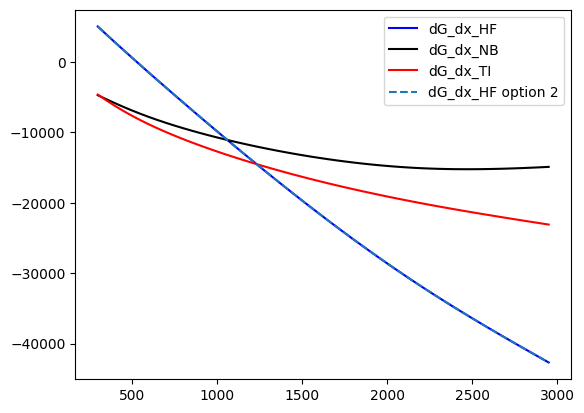

In [9]:
# To calculate Jansson derivatives, we first establish a Workspace with the specified conditions and then use "get" to run the equilibrium and 
# derivative calculation
# Here, I have specified the same composition at various temperatures, so the output of any "get" will be a vector
wks = Workspace(database=Database('HF_NB_TI_V.TDB'), components=['HF', 'NB', 'TI', 'V'], phases=['BCC_A2'],
                 conditions={v.X('HF'): 0.25, v.X('NB'): 0.25, v.X('TI'): 0.25, v.T: (300,3000,50), v.P: 101325})

# We need to make sure that we use IsolatedPhase so that the minimizer does not give us a solution with phase separation, but rather stays on the 
# free energy surface. First derivatives of the free energy wrt composition can be calculated with a Jansson derivative or by the relationship
# dG/dx_A = mu_A - mu_B where B is the dependent component
ip = IsolatedPhase('BCC_A2', wks=wks)
dG_dx_HF_option1 = wks.get(ip('GM.X(HF)'))
dG_dx_NB_option1 = wks.get(ip('GM.X(NB)'))
dG_dx_TI_option1 = wks.get(ip('GM.X(TI)'))
#dG_dx_V_option1 = wks.get(ip('GM.X(V)'))
dG_dx_HF_option2 = wks.get(ip('MU(HF)')) - wks.get(ip('MU(V)'))

# derivatives of chemical potential are found similarly
dmuHF_dx_HF = wks.get(ip('MU(HF).X(HF)'))

plt.figure(0)
plt.plot(np.arange(300,3000,50), dG_dx_HF_option1, c='blue', label='dG_dx_HF')
plt.plot(np.arange(300,3000,50), dG_dx_NB_option1, c='black', label='dG_dx_NB')
plt.plot(np.arange(300,3000,50), dG_dx_TI_option1, c='red', label='dG_dx_TI')
plt.plot(np.arange(300,3000,50), dG_dx_HF_option2, linestyle = 'dashed', label='dG_dx_HF option 2')
plt.legend()

## Compute Gibbs Free Energy of as a function of Nb Composition for Hf$_{0.15}$Nb$_{x}$Ti$_{0.05}$V$_{1-x}$

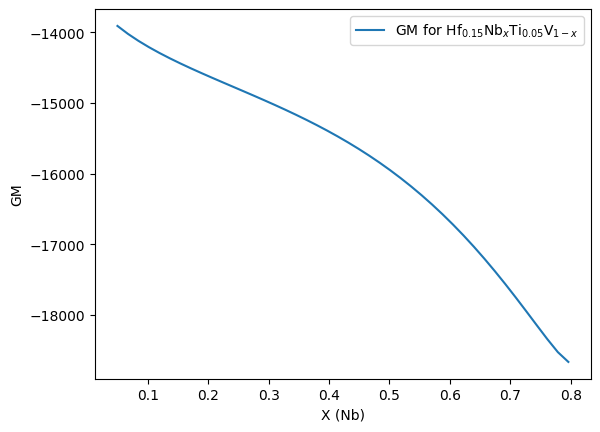

In [10]:
x_nb = np.linspace(0.05, 0.90, 50)
G = []
for x in x_nb:
    wks = Workspace(database=Database('HF_NB_TI_V.TDB'), components=['HF', 'NB', 'TI', 'V'], phases=['BCC_A2'],
            conditions={v.X('HF'): 0.15, v.X('NB'): x, v.X('TI'): 0.05, v.T: 500, v.P: 101325})
    ip = IsolatedPhase('BCC_A2', wks=wks)
    G.append(wks.get(ip('GM')))
plt.plot(x_nb,G, label=r"GM for Hf$_{0.15}$Nb$_{x}$Ti$_{0.05}$V$_{1-x}$")
plt.xlabel('X (Nb)')
plt.ylabel('GM')
#plt.title(r"GM for Hf$_{0.15}$Nb$_{x}$Ti$_{0.05}$V$_{1-x}$");
plt.legend()

# Modular code: Function for computing chemical potential 

{X_HF: 0.15, X_TI: 0.05, X_NB: 0.05, T: 500.0, P: 101325.0}
{X_HF: 0.15, X_TI: 0.05, X_NB: 0.09473684210526316, T: 500.0, P: 101325.0}
{X_HF: 0.15, X_TI: 0.05, X_NB: 0.1394736842105263, T: 500.0, P: 101325.0}
{X_HF: 0.15, X_TI: 0.05, X_NB: 0.1842105263157895, T: 500.0, P: 101325.0}
{X_HF: 0.15, X_TI: 0.05, X_NB: 0.22894736842105262, T: 500.0, P: 101325.0}
{X_HF: 0.15, X_TI: 0.05, X_NB: 0.2736842105263158, T: 500.0, P: 101325.0}
{X_HF: 0.15, X_TI: 0.05, X_NB: 0.31842105263157894, T: 500.0, P: 101325.0}
{X_HF: 0.15, X_TI: 0.05, X_NB: 0.36315789473684207, T: 500.0, P: 101325.0}
{X_HF: 0.15, X_TI: 0.05, X_NB: 0.40789473684210525, T: 500.0, P: 101325.0}
{X_HF: 0.15, X_TI: 0.05, X_NB: 0.45263157894736844, T: 500.0, P: 101325.0}
{X_HF: 0.15, X_TI: 0.05, X_NB: 0.49736842105263157, T: 500.0, P: 101325.0}
{X_HF: 0.15, X_TI: 0.05, X_NB: 0.5421052631578948, T: 500.0, P: 101325.0}
{X_HF: 0.15, X_TI: 0.05, X_NB: 0.5868421052631579, T: 500.0, P: 101325.0}
{X_HF: 0.15, X_TI: 0.05, X_NB: 0.631578947368

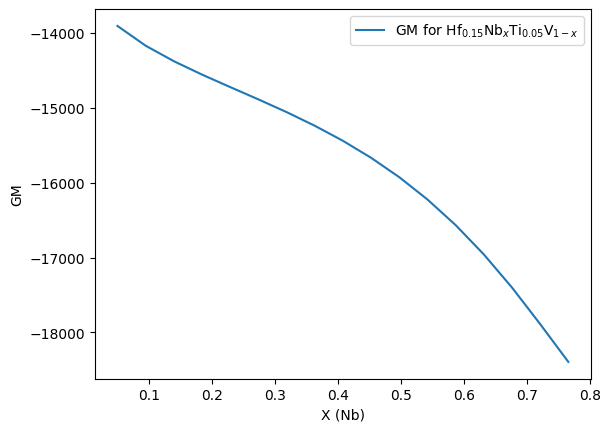

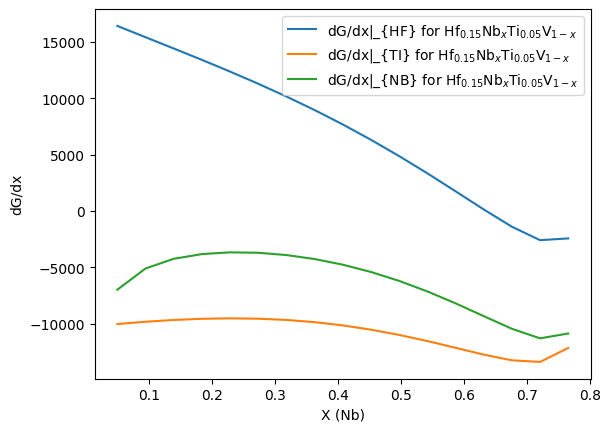

In [11]:
from pycalphad import variables as v

def build_conditions(variable_component, variable_value, fixed_composition, T, P=101325):
    """
    Construct pycalphad conditions with exactly three independent composition variables.

    Parameters:
    -----------
    variable_component : str
        The composition to sweep (e.g., 'NB')
    variable_value : float
        Value for the variable_component
    fixed_composition : dict
        Dictionary of the other two fixed components, e.g., {'HF': 0.15, 'TI': 0.05}
    T : float
        Temperature in Kelvin
    P : float
        Pressure in Pa

    Returns:
    --------
    dict
        pycalphad-compatible conditions with 3 independent composition variables
    """
    conditions = {v.X(k): float(fixed_composition[k]) for k in fixed_composition}
    conditions[v.X(variable_component)] = float(variable_value)
    conditions[v.T] = float(T)
    conditions[v.P] = float(P)

    print(conditions)

    return conditions

x_nb = np.linspace(0.05, 0.90, 20)
G = []
dG_dx_HF_option1 = []
dG_dx_NB_option1 = []
dG_dx_TI_option1 = []
for x in x_nb:

    conds = build_conditions(
        variable_component='NB',
        variable_value=x,
        fixed_composition={'HF': 0.15, 'TI': 0.05},
        T=500
    )
    #print(conds)
    
    wks = Workspace(database=Database('HF_NB_TI_V.TDB'), components=['HF', 'NB', 'TI', 'V'], phases=['BCC_A2'],
            conditions=conds)
    ip = IsolatedPhase('BCC_A2', wks=wks)
    G.append(wks.get(ip('GM')))
    dG_dx_HF_option1.append(wks.get(ip('GM.X(HF)')))
    dG_dx_NB_option1.append(wks.get(ip('GM.X(NB)')))
    dG_dx_TI_option1.append(wks.get(ip('GM.X(TI)')))

plt.plot(x_nb,G, label=r"GM for Hf$_{0.15}$Nb$_{x}$Ti$_{0.05}$V$_{1-x}$")
plt.xlabel('X (Nb)')
plt.ylabel('GM')
#plt.title(r"GM for Hf$_{0.15}$Nb$_{x}$Ti$_{0.05}$V$_{1-x}$");
plt.legend()

plt.figure()
plt.plot(x_nb,dG_dx_HF_option1, label=r"dG/dx|_{HF} for Hf$_{0.15}$Nb$_{x}$Ti$_{0.05}$V$_{1-x}$")
plt.plot(x_nb,dG_dx_TI_option1, label=r"dG/dx|_{TI} for Hf$_{0.15}$Nb$_{x}$Ti$_{0.05}$V$_{1-x}$")
plt.plot(x_nb,dG_dx_NB_option1, label=r"dG/dx|_{NB} for Hf$_{0.15}$Nb$_{x}$Ti$_{0.05}$V$_{1-x}$")
plt.xlabel('X (Nb)')
plt.ylabel('dG/dx')
#plt.title(r"GM for Hf$_{0.15}$Nb$_{x}$Ti$_{0.05}$V$_{1-x}$");
plt.legend()


In [12]:
def get_chemical_potential(x1, x2, x3, x4, temp ):
    """
    Construct chemical potential for phase-field modeling using three independent composition variables.

    Parameters:
    -----------
    x1 : float
        Hf Compostion
    x2 : float
        Nb Compostion
    x3 : float
        Ti Compostion
    x4 : float
        B Compostion
    fixed_composition : dict
        Dictionary of the other two fixed components, e.g., {'HF': 0.15, 'TI': 0.05}
    temp : float
        Temperature in Kelvin
    P : float
        Pressure in Pa

    Returns:
    --------
    dict
        pycalphad-compatible conditions with 3 independent composition variables
    """    

    G = []
    dG_dx_HF_option1 = []
    dG_dx_NB_option1 = []
    dG_dx_TI_option1 = []

    conds = build_conditions(
        variable_component='NB',
        variable_value=x2,
        fixed_composition={'HF': x1, 'TI': x3},
        T=temp
    )
    print(conds)
    
    wks = Workspace(database=Database('HF_NB_TI_V.TDB'), components=['HF', 'NB', 'TI', 'V'], phases=['BCC_A2'],
            conditions=conds)
    ip = IsolatedPhase('BCC_A2', wks=wks)
    G = wks.get(ip('GM'))
    dG_dx_HF_option1 = wks.get(ip('GM.X(HF)'))
    dG_dx_NB_option1 = wks.get(ip('GM.X(NB)'))
    dG_dx_TI_option1 = wks.get(ip('GM.X(TI)'))


    return G, dG_dx_HF_option1, dG_dx_NB_option1, dG_dx_TI_option1


x1 = 0.3
x2 = 0.25
x3 = 0.25
x4 = 1-x1-x2-x3
temp = 1000
G, dG_dx_HF_option1, dG_dx_NB_option1, dG_dx_TI_option1 = get_chemical_potential(x1=x1, x2=x2, x3=x3, x4=x4, temp=temp)

print(G, dG_dx_HF_option1, dG_dx_NB_option1, dG_dx_TI_option1)

{X_HF: 0.3, X_TI: 0.25, X_NB: 0.25, T: 1000.0, P: 101325.0}
{X_HF: 0.3, X_TI: 0.25, X_NB: 0.25, T: 1000.0, P: 101325.0}
-52797.810240064784 -11104.421871151542 -11195.603685170372 -13377.573056365372


In [13]:
def build_conditions(variable_component, variable_value, fixed_composition, T, P=101325):
    conditions = {v.X(k): float(fixed_composition[k]) for k in fixed_composition}
    conditions[v.X(variable_component)] = float(variable_value)
    conditions[v.T] = float(T)
    conditions[v.P] = float(P)
    return conditions

def get_chemical_potential_nd(x1_array, x2_array, x3_array, temp):
    """
    Generalized function to compute Gibbs energy and derivatives for nD arrays.

    Parameters:
    -----------
    x1_array, x2_array, x3_array : np.ndarray
        nD arrays of mole fractions (same shape).
    temp : float
        Temperature in Kelvin.

    Returns:
    --------
    Tuple of np.ndarrays: G, dG/dx_HF, dG/dx_NB, dG/dx_TI (same shape as inputs)
    """
    shape = x1_array.shape
    assert x1_array.shape == x2_array.shape == x3_array.shape, "All composition arrays must have the same shape."

    x1_flat = x1_array.flatten()
    x2_flat = x2_array.flatten()
    x3_flat = x3_array.flatten()

    G_list = []
    dG_dx_HF_list = []
    dG_dx_NB_list = []
    dG_dx_TI_list = []

    db = Database('HF_NB_TI_V.TDB')
    phase = 'BCC_A2'
    comps = ['HF', 'NB', 'TI', 'V']

    for x1, x2, x3 in zip(x1_flat, x2_flat, x3_flat):
        fixed_composition = {'HF': x1, 'TI': x3}
        conds = build_conditions('NB', x2, fixed_composition, T=temp)

        wks = Workspace(database=db, components=comps, phases=[phase], conditions=conds)
        ip = IsolatedPhase(phase, wks=wks)

        G_list.append(wks.get(ip('GM')).squeeze())
        dG_dx_HF_list.append(wks.get(ip('GM.X(HF)')).squeeze())
        dG_dx_NB_list.append(wks.get(ip('GM.X(NB)')).squeeze())
        dG_dx_TI_list.append(wks.get(ip('GM.X(TI)')).squeeze())

    # Reshape to original array shape
    G = np.array(G_list).reshape(shape)
    dGdx_HF = np.array(dG_dx_HF_list).reshape(shape)
    dGdx_NB = np.array(dG_dx_NB_list).reshape(shape)
    dGdx_TI = np.array(dG_dx_TI_list).reshape(shape)

    return G, dGdx_HF, dGdx_NB, dGdx_TI
    
# Create a 2D grid of compositions
x1, x2 = np.meshgrid(np.linspace(0.2, 0.4, 10), np.linspace(0.1, 0.3, 10))
x3 = 0.3 * np.ones_like(x1)  # Fixed third component
temp = 1000

G, dG_HF, dG_NB, dG_TI = get_chemical_potential_nd(x1, x2, x3, temp)

print(G)

[[            nan -50759.82779882 -50947.01646699 -51150.92310963
  -51370.71119376 -51605.3775361  -51853.77332232 -52114.60415002
  -52386.40894555 -52667.51406415]
 [-50905.72330307 -51082.75260584 -51276.51562014 -51486.37841798
  -51711.47494301 -51950.74689581 -52202.9562145  -52466.67257923
  -52740.23355584 -53021.66935971]
 [-51196.80955511 -51381.06241532 -51581.39200169 -51797.13485592
  -52027.3698302  -52270.94935449 -52526.49945476 -52792.38845117
  -53066.65777063 -53346.89880271]
 [-51468.40761265 -51659.85901624 -51866.66184825 -52088.09753909
  -52323.15567752 -52570.55278836 -52828.71352969 -53095.71008554
  -53369.14505651 -53645.94566252]
 [-51724.21404165 -51922.75343331 -52135.82504856 -52362.62106471
  -52601.99514872 -52852.46246824 -53112.15154451 -53378.69573416
  -53649.03346653 -53919.04945538]
 [-51966.93916853 -52172.34485406 -52391.33550409 -52622.96738894
  -52865.89281392 -53118.33080305 -53377.9710544  -53641.78275425
  -53905.66182483 -54163.76169585

T_vals size: 30
dG/dx_HF size: 30


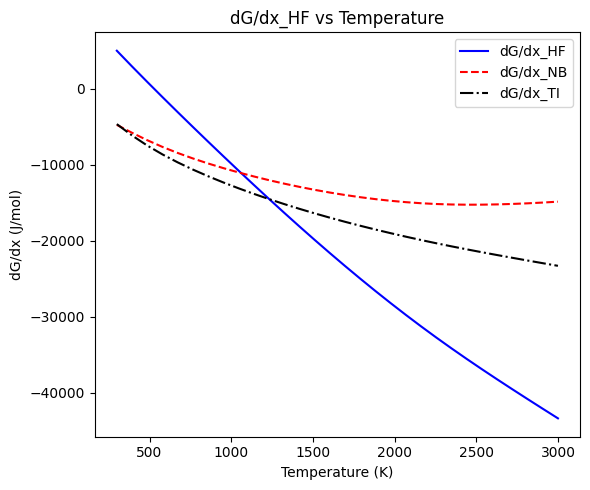

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from pycalphad import Database, variables as v
from pycalphad.core.workspace import Workspace

def compute_dGdx_from_mu(db_path, phase, composition_dict, T_range, P=101325, reference_component='V'):
    """
    Computes dG/dx_i using μ_i - μ_ref for fixed compositions in a quaternary system.

    Parameters:
    -----------
    db_path : str
        Path to the TDB file.
    phase : str
        Phase name (e.g., 'BCC_A2').
    composition_dict : dict
        Dict with 3 components fixed (e.g., {'HF': 0.25, 'NB': 0.25, 'TI': 0.25}).
    T_range : tuple
        (T_min, T_max, T_step)
    P : float
        Pressure
    reference_component : str
        The dependent component to use as reference (e.g., 'V')

    Returns:
    --------
    dict
        Dictionary with μ_i - μ_ref values (dG/dx_i equivalents).
    """
    
    T_min, T_max, T_step = T_range
    T_points = np.linspace(T_min, T_max, 30)  # Force exactly 50 points

    components = list(composition_dict.keys()) + [reference_component]
    conditions = {v.X(k): composition_dict[k] for k in composition_dict}
    conditions.update({v.T: T_points, v.P: P})

    db = Database(db_path)
    wks = Workspace(database=db, components=components, phases=[phase], conditions=conditions)
    ip = IsolatedPhase(phase, wks=wks)

    derivs = {}
    exprs = {'HF': 'GM.X(HF)', 'NB': 'GM.X(NB)', 'TI': 'GM.X(TI)'}
    for comp in composition_dict:
        dG_dx = wks.get(ip(exprs[comp]))
        derivs[comp] = dG_dx.squeeze()  # Remove singleton dimensions

    return derivs, T_points

# --- Usage Example ---
composition = {'HF': 0.25, 'NB': 0.25, 'TI': 0.25}
T_range = (300, 3000, 50)

dGdx, T_vals = compute_dGdx_from_mu(
    db_path='HF_NB_TI_V.TDB',
    phase='BCC_A2',
    composition_dict=composition,
    T_range=T_range
)

# Confirm matching sizes
print("T_vals size:", len(T_vals))
print("dG/dx_HF size:", len(dGdx['HF']))



# --- Plotting ---
plt.figure(figsize=(6, 5))
plt.plot(T_vals, dGdx['HF'], '-', c='blue', label='dG/dx_HF')
plt.plot(T_vals, dGdx['NB'], '--', c='red', label='dG/dx_NB')
plt.plot(T_vals, dGdx['TI'], '-.', c='black', label='dG/dx_TI')
plt.xlabel('Temperature (K)')
plt.ylabel('dG/dx (J/mol)')
plt.title('dG/dx_HF vs Temperature')
plt.legend()
#plt.grid(True)
plt.tight_layout()
plt.show()

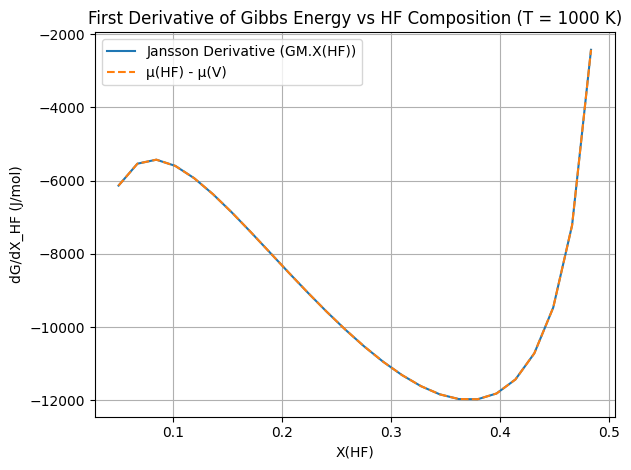

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from pycalphad import Workspace, Database, variables as v#, IsolatedPhase

# Sweep over HF composition (0.05 to 0.90)
x_hf = np.linspace(0.05, 0.90, 50)

# Lists to store derivatives
dG_dx_HF_opt1 = []
dG_dx_HF_opt2 = []

# Loop over composition values
for x in x_hf:
    wks = Workspace(
        database=Database('HF_NB_TI_V.TDB'),
        components=['HF', 'NB', 'TI', 'V'],
        phases=['BCC_A2'],
        conditions={
            v.X('HF'): x,
            v.X('NB'): 0.25,
            v.X('TI'): 0.25,
            v.T: 1000,       # fixed temperature
            v.P: 101325
        }
    )
    ip = IsolatedPhase('BCC_A2', wks=wks)
    d1 = wks.get(ip('GM.X(HF)')).squeeze()
    d2 = (wks.get(ip('MU(HF)')) - wks.get(ip('MU(V)'))).squeeze()
    
    dG_dx_HF_opt1.append(d1)
    dG_dx_HF_opt2.append(d2)

# Plot
plt.figure()
plt.plot(x_hf, dG_dx_HF_opt1, label='Jansson Derivative (GM.X(HF))')
plt.plot(x_hf, dG_dx_HF_opt2, '--', label='μ(HF) - μ(V)')
plt.xlabel('X(HF)')
plt.ylabel('dG/dX_HF (J/mol)')
plt.title('First Derivative of Gibbs Energy vs HF Composition (T = 1000 K)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

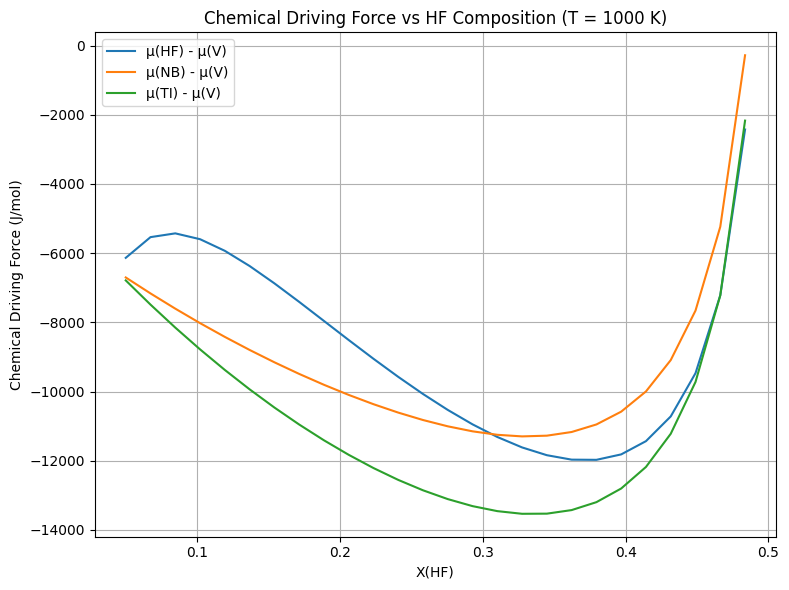

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from pycalphad import Workspace, Database, variables as v

# Sweep over HF composition
x_hf = np.linspace(0.05, 0.90, 50)

# Initialize dict to hold chemical driving forces for all elements
driving_forces = {el: [] for el in ['HF', 'NB', 'TI', 'V']}

# Loop over compositions
for x in x_hf:
    wks = Workspace(
        database=Database('HF_NB_TI_V.TDB'),
        components=['HF', 'NB', 'TI', 'V'],
        phases=['BCC_A2'],
        conditions={
            v.X('HF'): x,
            v.X('NB'): 0.25,
            v.X('TI'): 0.25,
            v.T: 1000,
            v.P: 101325
        }
    )
    ip = IsolatedPhase('BCC_A2', wks=wks)

    # Reference chemical potential (e.g., V)
    mu_ref = wks.get(ip('MU(V)')).squeeze()

    # Driving force: mu_i - mu_ref
    for el in driving_forces:
        mu_i = wks.get(ip(f'MU({el})')).squeeze()
        driving_forces[el].append(mu_i - mu_ref)

# Plotting
plt.figure(figsize=(8, 6))
for el, values in driving_forces.items():
    if el != 'V':  # V will have zero driving force (mu_i - mu_i = 0)
        plt.plot(x_hf, values, label=f'μ({el}) - μ(V)')

plt.xlabel('X(HF)')
plt.ylabel('Chemical Driving Force (J/mol)')
plt.title('Chemical Driving Force vs HF Composition (T = 1000 K)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

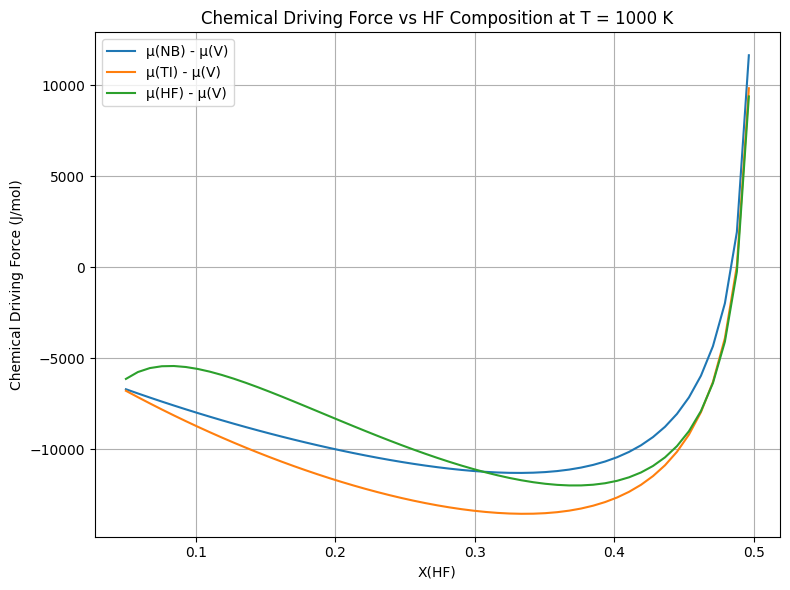

{'NB': [np.float64(-6701.451553056351),
  np.float64(-6932.727808013384),
  np.float64(-7158.564365480299),
  np.float64(-7379.045246882626),
  np.float64(-7594.246739191389),
  np.float64(-7804.2367490833785),
  np.float64(-8009.074088254762),
  np.float64(-8208.807680847596),
  np.float64(-8403.475682823417),
  np.float64(-8593.104500539215),
  np.float64(-8777.707695607322),
  np.float64(-8957.284758539055),
  np.float64(-9131.819732768563),
  np.float64(-9301.279666060043),
  np.float64(-9465.612863007082),
  np.float64(-9624.74690693515),
  np.float64(-9778.586413701465),
  np.float64(-9927.010472763955),
  np.float64(-10069.869721489034),
  np.float64(-10206.982988125055),
  np.float64(-10338.133424170112),
  np.float64(-10463.064030983383),
  np.float64(-10581.472462032616),
  np.float64(-10693.004956079581),
  np.float64(-10797.249220521633),
  np.float64(-10893.72603913719),
  np.float64(-10981.87931962822),
  np.float64(-11061.064219399712),
  np.float64(-11130.532886335015),

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from pycalphad import Workspace, Database, variables as v
#from pycalphad.core.isolated_phase import IsolatedPhase

def get_driving_force_vs_composition(
    db_path='HF_NB_TI_V.TDB',
    phase='BCC_A2',
    x_range=(0.05, 0.90),
    x_points=100,
    fixed_composition={'NB': 0.25, 'TI': 0.25},
    temperature=1000,
    pressure=101325,
    reference_element='V'
):
    """
    Compute and plot chemical driving forces (μ_i - μ_ref) for a range of X(HF),
    using Workspace directly (avoids IsolatedPhase and DOF issues).

    Parameters:
        db_path: Path to TDB file
        phase: Phase name to evaluate
        x_range: Tuple for HF composition range
        x_points: Number of points in sweep
        fixed_composition: Dict with fixed values for other components
        temperature: Temperature in Kelvin
        pressure: Pressure in Pa
        reference_element: Element to subtract from μ_i (e.g., 'V')

    Returns:
        driving_forces: Dict of {element: [values vs HF]}
    """
    
    x_hf = np.linspace(*x_range, x_points)
    elements = list(fixed_composition.keys()) + ['HF', reference_element]
    db = Database(db_path)

    driving_forces = {el: [] for el in elements}

    for x in x_hf:
        cond = {
            v.X('HF'): x,
            v.T: temperature,
            v.P: pressure
        }
        for el, val in fixed_composition.items():
            cond[v.X(el)] = val

        wks = Workspace(
            database=db,
            components=elements,
            phases=[phase],
            conditions=cond
        )

        #mu_ref = wks.get(f'MU({reference_element})').squeeze()
        #for el in driving_forces:
        #    mu_i = wks.get(f'MU({el})').squeeze()
        #    driving_forces[el].append(mu_i - mu_ref)

        ip = IsolatedPhase('BCC_A2', wks=wks)
        # Reference chemical potential (e.g., V)
        
        mu_ref = wks.get(ip('MU(V)')).squeeze()

        # Driving force: mu_i - mu_ref
        for el in driving_forces:
            mu_i = wks.get(ip(f'MU({el})')).squeeze()
            driving_forces[el].append(mu_i - mu_ref)
        

    # Plotting
    plt.figure(figsize=(8, 6))
    for el, values in driving_forces.items():
        if el != reference_element:
            plt.plot(x_hf, values, label=f'μ({el}) - μ({reference_element})')

    plt.xlabel('X(HF)')
    plt.ylabel('Chemical Driving Force (J/mol)')
    plt.title(f'Chemical Driving Force vs HF Composition at T = {temperature} K')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return driving_forces

get_driving_force_vs_composition(
    fixed_composition={'NB': 0.25, 'TI': 0.25},
    reference_element='V',
    temperature=1000
)

# Fit Polynomial

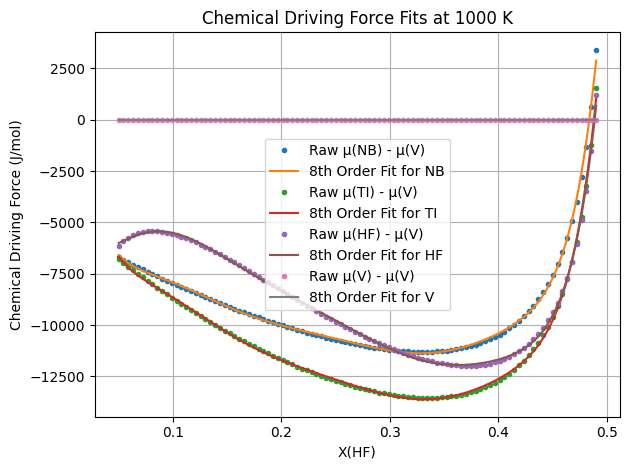

μ(HF) - μ(V) at 0.35: -9776.889
μ(NB) - μ(V) at 0.35: -10662.131
μ(TI) - μ(V) at 0.35: -12654.787


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from pycalphad import Workspace, Database, variables as v
from numpy.polynomial import Polynomial

def get_driving_force_vs_composition_with_fit(
    db_path='HF_NB_TI_V.TDB',
    phase='BCC_A2',
    x_range=(0.05, 0.49),
    x_points=100,
    fixed_composition={'NB': 0.25, 'TI': 0.25},
    temperature=1000,
    pressure=101325,
    reference_element='V',
    poly_order=8
):
    x_hf = np.linspace(*x_range, x_points)
    elements = list(fixed_composition.keys()) + ['HF', reference_element]
    db = Database(db_path)
    driving_forces = {el: [] for el in elements}

    for x in x_hf:
        cond = {v.X('HF'): x, v.T: temperature, v.P: pressure}
        for el, val in fixed_composition.items():
            cond[v.X(el)] = val

        wks = Workspace(database=db, components=elements, phases=[phase], conditions=cond)
        ip = IsolatedPhase(phase, wks=wks)
        mu_ref = wks.get(ip(f'MU({reference_element})')).squeeze()

        for el in driving_forces:
            mu_i = wks.get(ip(f'MU({el})')).squeeze()
            driving_forces[el].append(mu_i - mu_ref)


    # ✅ Fit polynomials in original domain (no scaling)
    poly_fits = {}
    fit_functions = {}
    for el, y_vals in driving_forces.items():
        y_vals = np.array(y_vals)
        if np.isnan(y_vals).any():
            print(f"Warning: NaNs in driving force for {el}, skipping fit.")
            continue
        coeffs = np.polyfit(x_hf, y_vals, poly_order)
        poly = np.poly1d(coeffs)
        poly_fits[el] = coeffs
        fit_functions[el] = poly
    
        # Optional plot
        x_fine = np.linspace(x_hf.min(), x_hf.max(), 300)
        y_fit = poly(x_fine)
        plt.plot(x_hf, y_vals, 'o', label=f'Raw μ({el}) - μ({reference_element})', markersize=3)
        plt.plot(x_fine, y_fit, '-', label=f'{poly_order}th Order Fit for {el}')
    


    plt.xlabel('X(HF)')
    plt.ylabel('Chemical Driving Force (J/mol)')
    plt.title(f'Chemical Driving Force Fits at {temperature} K')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #return driving_forces, poly_fits
    return driving_forces, poly_fits, fit_functions

# Example usage:
#driving_forces, mu_fits = get_driving_force_vs_composition_with_fit()
driving_forces, mu_coeffs, mu_functions = get_driving_force_vs_composition_with_fit()


# Evaluate at X(HF) = 0.35
mu_HF = mu_functions['HF'](0.25)
mu_NB = mu_functions['NB'](0.25)
mu_TI = mu_functions['TI'](0.25)

print(f"μ(HF) - μ(V) at 0.35: {mu_HF:.3f}")
print(f"μ(NB) - μ(V) at 0.35: {mu_NB:.3f}")
print(f"μ(TI) - μ(V) at 0.35: {mu_TI:.3f}")

# Microstructure Modeling using Real MLIP and Semi-Analytical Chemical Potentials

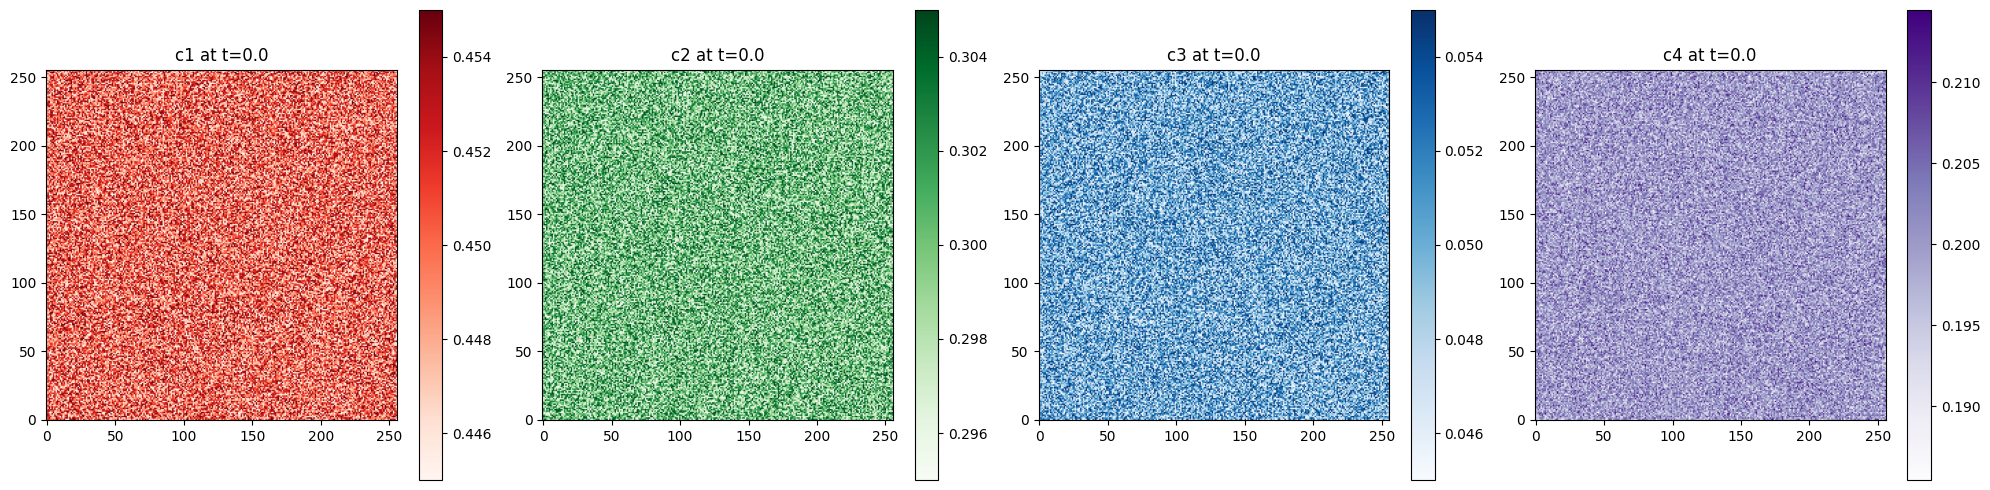

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▊ | 791/800 [00:09<00:00, 99.63it/s]

<Figure size 640x480 with 0 Axes>

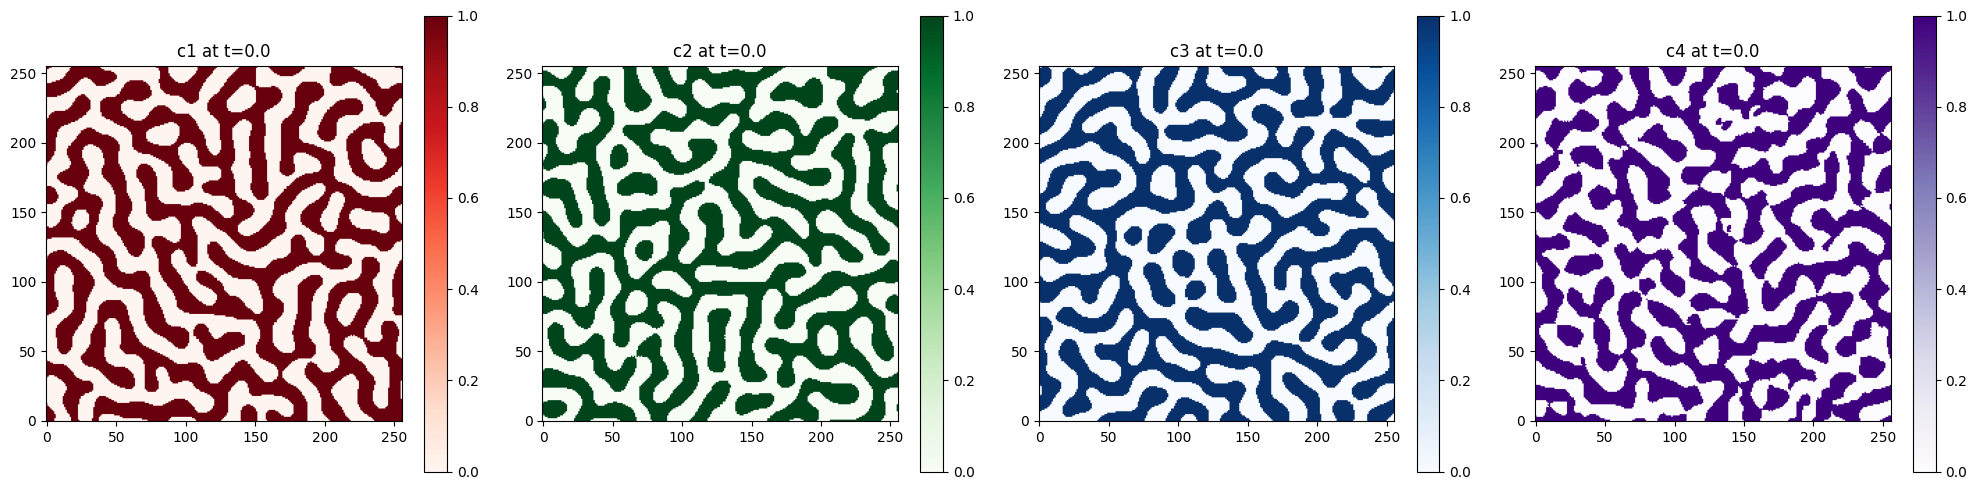

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:09<00:00, 81.04it/s]


In [19]:
# ==== Simulation Parameters ====
Kappa_c = 40.0e-19
M = 1.0
temp = 1000

# ==== Grid Setup ====
Lx = 100e-6
N = 256
h = Lx / (N - 1)
x = np.linspace(0, Lx, N)
y = x.copy()
xx, yy = np.meshgrid(x, y)

# ==== Spectral k-vectors ====
k = np.concatenate((np.arange(0, N//2), [0], np.arange(-N//2+1, 0)))
g = 2 * np.pi / Lx
kx = g * 1j * k
ky = g * 1j * k
kx, ky = np.meshgrid(kx, ky)
k2 = kx**2 + ky**2

# ==== Initial Conditions ====
np.random.seed(0)
c1 = 0.45 + 0.01 * (np.random.rand(N, N) - 0.5) # HF
c2 = 0.3 + 0.01 * (np.random.rand(N, N) - 0.5) # NB
c3 = 0.05 + 0.01 * (np.random.rand(N, N) - 0.5) # TI
c4 = 1.0 - c1 - c2 - c3

n = 0
plt.figure(figsize=(20, 5))
for idx, (c, label, cmap) in enumerate(zip([c1, c2, c3, c4], ['c1', 'c2', 'c3', 'c4'], ['Reds', 'Greens', 'Blues', 'Purples'])):
    plt.subplot(1, 4, idx+1)
    plt.imshow(c, cmap=cmap, origin='lower')
    plt.title(f'{label} at t={n*dt:.1f}')
    plt.colorbar()
    plt.tight_layout()

plt.show()
plt.savefig(f'microstructure-quaternary-real/quaternary_frame_{n}.jpg')


# ==== Time Setup ====
dt = 0.05e-5
tmax = 40e-5
max_iter = int(tmax / dt)
plot_indices = np.linspace(0, max_iter, 20, dtype=int)

# ==== Output Directory ====
if os.path.exists("microstructure-quaternary-real"):
    os.system("rm -r microstructure-quaternary-real")
os.makedirs("microstructure-quaternary-real", exist_ok=True)

# PyCalphad Direct Call (slow)
#G, dG_dx_HF_option1, dG_dx_NB_option1, dG_dx_TI_option1 = get_chemical_potential_nd(c1, c2, c3, temp=temp)
#print(G, dG_dx_HF_option1, dG_dx_NB_option1, dG_dx_TI_option1) 
#pause


# ==== Simulation Loop ====
for n in tqdm(range(1, max_iter + 1)):
    #print('iter ',n)
    c4 = 1.0 - c1 - c2 - c3

    # PyCalphad Direct Call (slow)
    #G, mu1, mu2, mu3 = get_chemical_potential_nd(c1, c2, c3, temp)

    # Polynomial fit call (fast)
    mu1 = mu_functions['HF'](c1)
    mu2 = mu_functions['NB'](c2)
    mu3 = mu_functions['TI'](c3)

    mu1_hat = fft2(mu1)
    mu2_hat = fft2(mu2)
    mu3_hat = fft2(mu3)

    c1_hat = fft2(c1)
    c2_hat = fft2(c2)
    c3_hat = fft2(c3)

    denom = 1 + 2 * M * Kappa_c * dt * k2**2

    c1 = np.real(ifft2((c1_hat + M * dt * k2 * mu1_hat) / denom))
    c2 = np.real(ifft2((c2_hat + M * dt * k2 * mu2_hat) / denom))
    c3 = np.real(ifft2((c3_hat + M * dt * k2 * mu3_hat) / denom))
    c4 = 1.0 - c1 - c2 - c3

    # Clip to physical range
    c1 = np.clip(c1, 0.0, 1.0)
    c2 = np.clip(c2, 0.0, 1.0)
    c3 = np.clip(c3, 0.0, 1.0)
    c4 = np.clip(c4, 0.0, 1.0)

    if n == 1 or n in plot_indices or n == max_iter:
        plt.figure(figsize=(20, 5))
        for idx, (c, label, cmap) in enumerate(zip([c1, c2, c3, c4], ['c1', 'c2', 'c3', 'c4'], ['Reds', 'Greens', 'Blues', 'Purples'])):
            plt.subplot(1, 4, idx+1)
            plt.imshow(c, cmap=cmap, origin='lower')
            plt.title(f'{label} at t={n*dt:.1f}')
            plt.colorbar()
        plt.tight_layout()
        plt.savefig(f'microstructure-quaternary-real/quaternary_frame_{n}.jpg')
        if n == max_iter:
            plt.show()
        plt.close()

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from pycalphad import Workspace, Database, variables as v
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def get_driving_force_multivariate_fit(
    db_path='HF_NB_TI_V.TDB',
    phase='BCC_A2',
    x_hf_range=(0.155, 0.45),
    x_nb_range=(0.1, 0.45),
    x_points=20,
    fixed_composition={'TI': 0.25},
    temperature=1000,
    pressure=101325,
    reference_element='V',
    poly_order=2
):
    x_hf = np.linspace(*x_hf_range, x_points)
    x_nb = np.linspace(*x_nb_range, x_points)
    grid_hf, grid_nb = np.meshgrid(x_hf, x_nb)
    x_flat = grid_hf.ravel()
    y_flat = grid_nb.ravel()

    elements = list(fixed_composition.keys()) + ['HF', 'NB', reference_element]
    db = Database(db_path)

    comps = []
    driving_forces = {el: [] for el in elements}

    for xi, yi in zip(x_flat, y_flat):
        x_ti = fixed_composition['TI']
        if xi + yi + x_ti > 1.0:  # skip invalid compositions
            continue

        cond = {v.X('HF'): xi, v.X('NB'): yi, v.X('TI'): x_ti,
                v.T: temperature, v.P: pressure}

        comps.append([xi, yi])  # store HF and NB as features

        wks = Workspace(database=db, components=elements, phases=[phase], conditions=cond)
        ip = IsolatedPhase(phase, wks=wks)
        mu_ref = wks.get(ip(f'MU({reference_element})')).squeeze()

        for el in driving_forces:
            mu_i = wks.get(ip(f'MU({el})')).squeeze()
            if np.isnan(mu_i) or np.isnan(mu_ref):
                print(f"NaN encountered at composition: HF={xi}, NB={yi}")
            driving_forces[el].append(mu_i - mu_ref)


    
    # Polynomial regression fit
    comps = np.array(comps)
    poly = PolynomialFeatures(degree=poly_order)
    X_poly = poly.fit_transform(comps)

    fit_models = {}
    for el, y_vals in driving_forces.items():
        y_vals = np.array(y_vals)
        nan_mask = ~np.isnan(y_vals)
        if nan_mask.sum() < 5:
            print(f"Not enough valid data for {el}, skipping.")
            continue
        model = LinearRegression().fit(X_poly[nan_mask], y_vals[nan_mask])
        fit_models[el] = model
        
    return comps, driving_forces, fit_models, poly

comps, df_values, models, transformer = get_driving_force_multivariate_fit()

# Evaluate driving force for HF at X(HF)=0.3, X(NB)=0.2
X_eval = transformer.transform([[0.3, 0.2]])
mu_HF = models['HF'].predict(X_eval)[0]
print(f"Δμ(HF) at X(HF)=0.3, X(NB)=0.2: {mu_HF:.3f}")

/Users/attari.v/Documents/PROJECTS/pycalphad/pycalphad/io/tdb.py:995: UserWarning: The type definition character `%` was defined in the following phases: ['BCC_A2', 'HCP_A3'], but no corresponding TYPE_DEFINITION line was found in the TDB.
  warnings.warn(f"The type definition character `{typechar}` was defined in the following phases: "


Δμ(HF) at X(HF)=0.3, X(NB)=0.2: -11473.069


# ------------------------------------------------------------------------------
# Polynomial Fitting of Chemical Driving Forces (Δμ = μ_i - μ_V)
# ------------------------------------------------------------------------------

# Step 1: Generate Composition Grid
# - Iterate over HF, NB, and TI mole fractions.
# - Enforce mass balance: x_HF + x_NB + x_TI + x_V = 1.0
# - x_V is computed as 1 - (x_HF + x_NB + x_TI)

# Step 2: Evaluate Chemical Potentials
# - Use pycalphad Workspace and IsolatedPhase to evaluate μ_i and μ_V
# - Calculate driving force: Δμ_i = μ_i - μ_V for each element i

# Step 3: Fit Polynomial Regression Models
# - Use sklearn's PolynomialFeatures to expand input features to desired degree
# - Use LinearRegression to fit a separate model for each element's Δμ
# - NaNs are filtered before fitting

# Step 4: Evaluate Fit Quality
# - Use sklearn metrics:
#     - RMSE: Root Mean Squared Error of the predictions
#     - R² Score: Coefficient of determination
# - Compare predicted vs. true Δμ to verify model accuracy

# Notes:
# - Higher polynomial degrees may overfit; monitor R² and RMSE trends
# - The fitted model enables fast estimation of Δμ at new compositions
# - Can be used for contour mapping, phase transformation driving force estimates, etc.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from pycalphad import Workspace, Database, variables as v
from pycalphad.plot.utils import phase_legend
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


def get_driving_force_3D_fit_balanced(
    db_path='HF_NB_TI_V.TDB',
    phase='BCC_A2',
    hf_range=(0.05, 0.6),
    nb_range=(0.05, 0.6),
    ti_range=(0.05, 0.6),
    x_points=10,
    temperature=1000,
    pressure=101325,
    reference_element='V',
    poly_order=5,
    tolerance=1e-6
):
    x_hf_vals = np.linspace(*hf_range, x_points)
    x_nb_vals = np.linspace(*nb_range, x_points)
    x_ti_vals = np.linspace(*ti_range, x_points)

    elements = ['HF', 'NB', 'TI', reference_element]
    db = Database(db_path)

    comps = []
    driving_forces = {el: [] for el in elements}

    for x_hf in x_hf_vals:
        for x_nb in x_nb_vals:
            for x_ti in x_ti_vals:
                x_total = x_hf + x_nb + x_ti
                x_v = 1.0 - x_total

                if x_v < 0 or x_v > 1.0 or abs(x_hf + x_nb + x_ti + x_v - 1.0) > tolerance:
                    continue  # skip invalid or ill-conditioned compositions
                if x_total > 1:
                    continue  # skip invalid or ill-conditioned compositions

                cond = {
                    v.X('HF'): x_hf,
                    v.X('NB'): x_nb,
                    v.X('TI'): x_ti,
                    v.T: temperature,
                    v.P: pressure
                }

                try:
                    wks = Workspace(database=db, components=elements, phases=[phase], conditions=cond)
                    ip = IsolatedPhase(phase, wks=wks)
                    mu_ref = wks.get(ip(f'MU({reference_element})')).squeeze()
                    comps.append([x_hf, x_nb, x_ti])

                    for el in driving_forces:
                        mu_i = wks.get(ip(f'MU({el})')).squeeze()
                        driving_forces[el].append(mu_i - mu_ref)
                except Exception as e:
                    print(f"Skipping HF={x_hf:.2f}, NB={x_nb:.2f}, TI={x_ti:.2f}, V={x_v:.2f}: {e}")
                    continue

    comps = np.array(comps)
    poly = PolynomialFeatures(degree=poly_order)
    X_poly = poly.fit_transform(comps)

    fit_models = {}
    for el, y_vals in driving_forces.items():
        y_vals = np.array(y_vals)
        nan_mask = ~np.isnan(y_vals)
        if nan_mask.sum() < 5:
            print(f"Not enough valid data for {el}, skipping.")
            continue
        model = LinearRegression().fit(X_poly[nan_mask], y_vals[nan_mask])
        fit_models[el] = model

    
    print("\n--- Fit Quality Report ---")
    for el, model in fit_models.items():
        y_true = np.array(driving_forces[el])
        X = poly.transform(comps)
            
        # Filter out NaNs again
        nan_mask = ~np.isnan(y_true)
        y_true = y_true[nan_mask]
        X = X[nan_mask]
    
        y_pred = model.predict(X)
    
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
    
        print(f"{el}:")
        print(f"  RMSE: {rmse:.2f} J/mol")
        print(f"  R² Score: {r2:.4f}")

    return comps, driving_forces, fit_models, poly


## call function

comps, df_vals, models, transformer = get_driving_force_3D_fit_balanced(
    db_path='HF_NB_TI_V.TDB',
    phase='BCC_A2',
    hf_range=(0.05, 0.95),
    nb_range=(0.05, 0.95),
    ti_range=(0.05, 0.95),
    x_points=20,
    temperature=1000,
    pressure=101325,
    reference_element='V',
    poly_order=3,
    tolerance=1e-6
)


print("\n--- Example Calculation ---")
# Predict for HF=0.25, NB=0.25, TI=0.25 → V will be 0.25
X_eval = transformer.transform([[0.25, 0.25, 0.25]])
mu_HF = models['HF'].predict(X_eval)[0]
mu_NB = models['NB'].predict(X_eval)[0]
mu_TI = models['TI'].predict(X_eval)[0]
print(f"Δμ(HF) at HF=0.25, NB=0.25, TI=0.25: {mu_HF:.3f}")
print(f"Δμ(NB) at HF=0.25, NB=0.25, TI=0.25: {mu_NB:.3f}")
print(f"Δμ(TI) at HF=0.25, NB=0.25, TI=0.25: {mu_TI:.3f}")

/Users/attari.v/Documents/PROJECTS/pycalphad/pycalphad/io/tdb.py:995: UserWarning: The type definition character `%` was defined in the following phases: ['BCC_A2', 'HCP_A3'], but no corresponding TYPE_DEFINITION line was found in the TDB.
  warnings.warn(f"The type definition character `{typechar}` was defined in the following phases: "



--- Fit Quality Report ---
HF:
  RMSE: 781.74 J/mol
  R² Score: 0.9697
NB:
  RMSE: 780.84 J/mol
  R² Score: 0.9795
TI:
  RMSE: 783.05 J/mol
  R² Score: 0.9904
V:
  RMSE: 0.00 J/mol
  R² Score: 0.0112

--- Example Calculation ---
Δμ(HF) at HF=0.25, NB=0.25, TI=0.25: -9928.514
Δμ(NB) at HF=0.25, NB=0.25, TI=0.25: -10808.085
Δμ(TI) at HF=0.25, NB=0.25, TI=0.25: -12803.138


In [22]:
target_comp = np.array([0.25, 0.25, 0.25])
distances = np.linalg.norm(comps - target_comp, axis=1)
closest_idx = np.argmin(distances)

print("Closest comp:", comps[closest_idx])
print("True Δμ(HF):", df_vals['HF'][closest_idx])
print("True Δμ(NB):", df_vals['NB'][closest_idx])
print("True Δμ(TI):", df_vals['TI'][closest_idx])
print("Fitted Δμ(HF):", models['HF'].predict(transformer.transform([target_comp]))[0])
print("Fitted Δμ(NB):", models['NB'].predict(transformer.transform([target_comp]))[0])
print("Fitted Δμ(TI):", models['TI'].predict(transformer.transform([target_comp]))[0])

Closest comp: [0.23947368 0.23947368 0.23947368]
True Δμ(HF): -9183.998116059993
True Δμ(NB): -10805.259591185568
True Δμ(TI): -12900.330474889459
Fitted Δμ(HF): -9928.514371672185
Fitted Δμ(NB): -10808.084791945708
Fitted Δμ(TI): -12803.137700236424



--- Evaluating Polynomial Order 1 ---


/Users/attari.v/Documents/PROJECTS/pycalphad/pycalphad/io/tdb.py:995: UserWarning: The type definition character `%` was defined in the following phases: ['BCC_A2', 'HCP_A3'], but no corresponding TYPE_DEFINITION line was found in the TDB.
  warnings.warn(f"The type definition character `{typechar}` was defined in the following phases: "


HF: RMSE=5056.49 J/mol, R²=0.1198
NB: RMSE=4682.82 J/mol, R²=0.6092
TI: RMSE=4769.17 J/mol, R²=0.7683

--- Evaluating Polynomial Order 2 ---


/Users/attari.v/Documents/PROJECTS/pycalphad/pycalphad/io/tdb.py:995: UserWarning: The type definition character `%` was defined in the following phases: ['BCC_A2', 'HCP_A3'], but no corresponding TYPE_DEFINITION line was found in the TDB.
  warnings.warn(f"The type definition character `{typechar}` was defined in the following phases: "


HF: RMSE=2948.14 J/mol, R²=0.7008
NB: RMSE=3106.24 J/mol, R²=0.8281
TI: RMSE=3137.28 J/mol, R²=0.8997

--- Evaluating Polynomial Order 3 ---


/Users/attari.v/Documents/PROJECTS/pycalphad/pycalphad/io/tdb.py:995: UserWarning: The type definition character `%` was defined in the following phases: ['BCC_A2', 'HCP_A3'], but no corresponding TYPE_DEFINITION line was found in the TDB.
  warnings.warn(f"The type definition character `{typechar}` was defined in the following phases: "


HF: RMSE=1776.74 J/mol, R²=0.8913
NB: RMSE=1776.18 J/mol, R²=0.9438
TI: RMSE=1778.48 J/mol, R²=0.9678

--- Evaluating Polynomial Order 4 ---


/Users/attari.v/Documents/PROJECTS/pycalphad/pycalphad/io/tdb.py:995: UserWarning: The type definition character `%` was defined in the following phases: ['BCC_A2', 'HCP_A3'], but no corresponding TYPE_DEFINITION line was found in the TDB.
  warnings.warn(f"The type definition character `{typechar}` was defined in the following phases: "


HF: RMSE=1005.01 J/mol, R²=0.9652
NB: RMSE=1003.48 J/mol, R²=0.9821
TI: RMSE=1005.05 J/mol, R²=0.9897

--- Evaluating Polynomial Order 5 ---


/Users/attari.v/Documents/PROJECTS/pycalphad/pycalphad/io/tdb.py:995: UserWarning: The type definition character `%` was defined in the following phases: ['BCC_A2', 'HCP_A3'], but no corresponding TYPE_DEFINITION line was found in the TDB.
  warnings.warn(f"The type definition character `{typechar}` was defined in the following phases: "


HF: RMSE=524.65 J/mol, R²=0.9905
NB: RMSE=525.48 J/mol, R²=0.9951
TI: RMSE=525.09 J/mol, R²=0.9972

--- Evaluating Polynomial Order 6 ---


/Users/attari.v/Documents/PROJECTS/pycalphad/pycalphad/io/tdb.py:995: UserWarning: The type definition character `%` was defined in the following phases: ['BCC_A2', 'HCP_A3'], but no corresponding TYPE_DEFINITION line was found in the TDB.
  warnings.warn(f"The type definition character `{typechar}` was defined in the following phases: "


HF: RMSE=260.82 J/mol, R²=0.9977
NB: RMSE=261.02 J/mol, R²=0.9988
TI: RMSE=261.06 J/mol, R²=0.9993


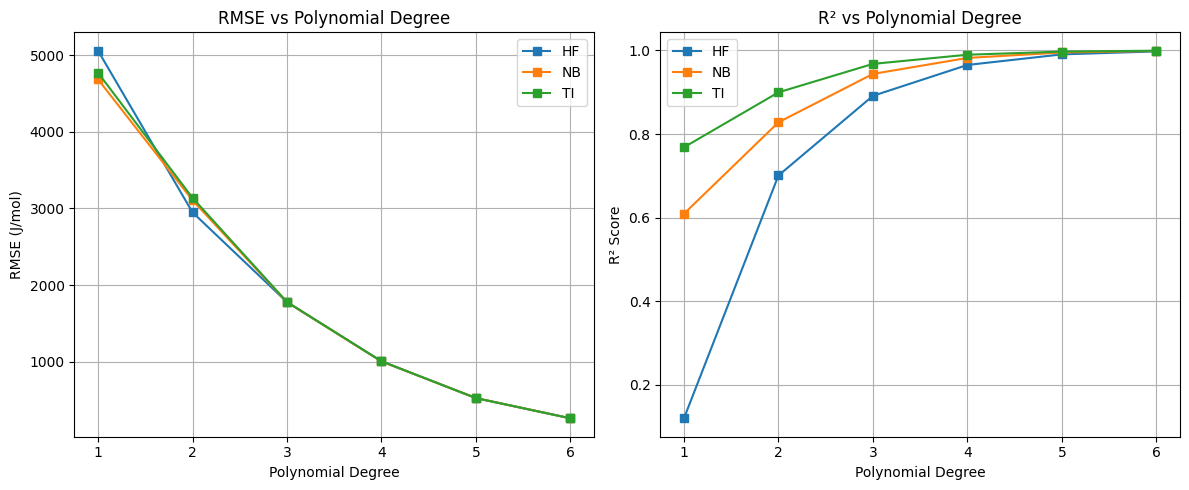

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from pycalphad import Database, Workspace, variables as v
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# ------------------------------------------------------------------------------
# Function to Generate Composition Grid and Fit Driving Forces
# ------------------------------------------------------------------------------

def get_driving_force_3D_fit_balanced(
    db_path='HF_NB_TI_V.TDB',
    phase='BCC_A2',
    hf_range=(0.05, 0.6),
    nb_range=(0.05, 0.6),
    ti_range=(0.05, 0.6),
    x_points=10,
    temperature=1000,
    pressure=101325,
    reference_element='V',
    poly_order=3,
    tolerance=1e-6
):
    x_hf_vals = np.linspace(*hf_range, x_points)
    x_nb_vals = np.linspace(*nb_range, x_points)
    x_ti_vals = np.linspace(*ti_range, x_points)

    elements = ['HF', 'NB', 'TI', reference_element]
    db = Database(db_path)

    valid_comps = []
    driving_forces = {el: [] for el in ['HF', 'NB', 'TI']}  # Only non-ref elements

    for x_hf in x_hf_vals:
        for x_nb in x_nb_vals:
            for x_ti in x_ti_vals:
                x_total = x_hf + x_nb + x_ti
                x_v = 1.0 - x_total
                if x_v < 0 or x_v > 1.0 or abs(x_total + x_v - 1.0) > tolerance:
                    continue

                cond = {
                    v.X('HF'): x_hf,
                    v.X('NB'): x_nb,
                    v.X('TI'): x_ti,
                    v.T: temperature,
                    v.P: pressure
                }

                try:
                    wks = Workspace(database=db, components=elements, phases=[phase], conditions=cond)
                    ip = IsolatedPhase(phase, wks=wks)
                    mu_ref = wks.get(ip(f'MU({reference_element})')).squeeze()

                    mu_i_vals = {}
                    all_valid = True
                    for el in driving_forces:
                        mu_i = wks.get(ip(f'MU({el})')).squeeze()
                        if np.isnan(mu_i):
                            all_valid = False
                            break
                        mu_i_vals[el] = mu_i

                    if all_valid:
                        valid_comps.append([x_hf, x_nb, x_ti])
                        for el in driving_forces:
                            driving_forces[el].append(mu_i_vals[el] - mu_ref)

                except Exception as e:
                    print(f"Skipping HF={x_hf:.2f}, NB={x_nb:.2f}, TI={x_ti:.2f}, V={x_v:.2f}: {e}")
                    continue

    comps = np.array(valid_comps)
    poly = PolynomialFeatures(degree=poly_order)
    X_poly = poly.fit_transform(comps)

    fit_models = {}
    for el, y_vals in driving_forces.items():
        y_vals = np.array(y_vals)
        if np.sum(~np.isnan(y_vals)) < 5:
            print(f"Not enough data for {el}, skipping.")
            continue
        model = LinearRegression().fit(X_poly, y_vals)
        fit_models[el] = model

    return comps, driving_forces, fit_models, poly

# ------------------------------------------------------------------------------
# Function to Evaluate Fit Quality Over Polynomial Orders
# ------------------------------------------------------------------------------

def evaluate_poly_orders(order_range=(1, 6), **kwargs):
    results = {el: {"rmse": [], "r2": []} for el in ['HF', 'NB', 'TI']}

    for order in range(order_range[0], order_range[1] + 1):
        print(f"\n--- Evaluating Polynomial Order {order} ---")
        comps, df_vals, models, transformer = get_driving_force_3D_fit_balanced(
            poly_order=order,
            **kwargs
        )

        for el in ['HF', 'NB', 'TI']:
            if el not in models:
                results[el]["rmse"].append(np.nan)
                results[el]["r2"].append(np.nan)
                continue

            y_true = np.array(df_vals[el])
            X = transformer.transform(comps)
            y_pred = models[el].predict(X)

            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            r2 = r2_score(y_true, y_pred)

            print(f"{el}: RMSE={rmse:.2f} J/mol, R²={r2:.4f}")
            results[el]["rmse"].append(rmse)
            results[el]["r2"].append(r2)

    # Plot
    degrees = list(range(order_range[0], order_range[1] + 1))
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    for el in ['HF', 'NB', 'TI']:
        axs[0].plot(degrees, results[el]["rmse"], '-s', label=el)
        axs[1].plot(degrees, results[el]["r2"], '-s', label=el)

    axs[0].set_title("RMSE vs Polynomial Degree")
    axs[0].set_xlabel("Polynomial Degree")
    axs[0].set_ylabel("RMSE (J/mol)")
    axs[0].legend()
    axs[0].grid(True)

    axs[1].set_title("R² vs Polynomial Degree")
    axs[1].set_xlabel("Polynomial Degree")
    axs[1].set_ylabel("R² Score")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

evaluate_poly_orders(
    order_range=(1, 6),
    db_path='HF_NB_TI_V.TDB',
    phase='BCC_A2',
    hf_range=(0.05, 0.95),
    nb_range=(0.05, 0.95),
    ti_range=(0.05, 0.95),
    x_points=15,
    temperature=1000,
    pressure=101325,
    reference_element='V'
)

In [24]:
!pip install python-ternary

In [34]:
import ternary
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np

def barycentric_to_cartesian(hf, nb, ti):
    # Convert barycentric (HF, NB, TI) to 2D Cartesian for plotting
    x = 0.5 * (2*nb + ti)
    y = (np.sqrt(3)/2) * ti
    return x, y

def plot_driving_force_with_matplotlib(comps, driving_force, element='HF', fontsize=14, n_contours=10):
    hf = np.array([c[0] for c in comps])
    nb = np.array([c[1] for c in comps])
    ti = 1.0 - hf - nb
    z = np.array(driving_force[element])

    x, y = barycentric_to_cartesian(hf, nb, ti)
    triang = tri.Triangulation(x, y)

    fig, ax = plt.subplots(figsize=(7.5, 6.8))
    tpc = ax.tripcolor(triang, z, cmap='viridis', shading='gouraud')

    # Slim colorbar on the right
    cbar_ax = fig.add_axes([0.77, 0.2, 0.015, 0.6])  # [left, bottom, width, height]
    cbar = plt.colorbar(tpc, cax=cbar_ax)
    cbar.set_label(f'Δμ({element}) [J/mol]', fontsize=fontsize-2)
    cbar.ax.tick_params(labelsize=fontsize-4)  # Smaller ticks
    
    # Contour lines
    contours = ax.tricontour(triang, z, levels=n_contours, colors='k', linewidths=0.75)
    ax.clabel(contours, inline=True, fontsize=fontsize-5, fmt="%.0f")

    # Triangle border
    triangle_x = [0, 1, 0.5, 0]
    triangle_y = [0, 0, np.sqrt(3)/2, 0]
    ax.plot(triangle_x, triangle_y, 'k-', lw=2)

    # Corner labels
    ax.text(-0.04, -0.04, 'HF', ha='right', va='top', fontsize=fontsize, weight='bold')
    ax.text(1.04, -0.04, 'NB', ha='left', va='top', fontsize=fontsize, weight='bold')
    ax.text(0.5, np.sqrt(3)/2 + 0.04, 'TI', ha='center', va='bottom', fontsize=fontsize, weight='bold')

    # Ticks on HF-NB edge (TI = 0)
    for i in np.linspace(0.1, 0.9, 5):
        x, y = barycentric_to_cartesian(i, 1 - i, 0)
        ax.text(x, y - 0.04, f"{i:.1f}", ha='center', va='top', fontsize=fontsize-4)
    
    # Ticks on NB-TI edge (HF = 0)
    for i in np.linspace(0.1, 0.9, 5):
        x, y = barycentric_to_cartesian(0, i, 1 - i)
        ax.text(x + 0.03, y, f"{i:.1f}", ha='left', va='center', fontsize=fontsize-4)
    
    # Ticks on TI-HF edge (NB = 0)
    for i in np.linspace(0.1, 0.9, 5):
        x, y = barycentric_to_cartesian(i, 0, 1 - i)
        ax.text(x - 0.03, y, f"{i:.1f}", ha='right', va='center', fontsize=fontsize-4)

    ax.set_title(f"Δμ({element}) Ternary Map (HF-NB-TI)", fontsize=fontsize+1, pad=15)
    ax.set_aspect('equal')
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, np.sqrt(3)/2 + 0.1)
    ax.axis('off')
    plt.tight_layout(rect=[0, 0, 0.83, 1])  # Adjust layout to make room for colorbar
    plt.show()

def plot_driving_force_ternary(comps, driving_force, element='HF'):
    import ternary
    import matplotlib.pyplot as plt

    scale = 1.0
    data = {}

    for idx, (x_hf, x_nb, x_v) in enumerate(comps):
        x_ti = 1.0 - x_hf - x_nb - x_v
        if x_ti < 0.0 or x_ti > 1.0:
            continue
    
        key = (round(float(x_hf), 4), round(float(x_nb), 4), round(float(x_ti), 4))
        value = float(driving_force[element][idx])
        data[key] = value

    if not data:
        raise ValueError("No valid data points in ternary map — check composition constraints.")

    #print(data)

    print("Sample key:", list(data.keys())[0])
    print("Type of entries in key:", [type(x) for x in list(data.keys())[0]])
    
    fig, ax = plt.subplots(figsize=(8, 7))
    tax = ternary.TernaryAxesSubplot(ax=ax, scale=scale)
    tax.set_title(f"Δμ({element}) Ternary Map (HF-NB-TI)", fontsize=14)
    tax.boundary(linewidth=2.0)
    tax.gridlines(color="gray", multiple=0.1)
    tax.ticks(axis='lbr', linewidth=1, multiple=0.1, tick_formats="%.1f")

    tax.heatmap(data, style="triangular", cmap='viridis', colorbar=True)
    tax.left_axis_label("NB", fontsize=12)
    tax.right_axis_label("TI", fontsize=12)
    tax.bottom_axis_label("HF", fontsize=12)
    tax.clear_matplotlib_ticks()

    # Optional debug scatter overlay
    #tax.scatter(list(data.keys()), marker='o', color='red', s=5)

    tax.show()

In [26]:
comps, df_vals, models, transformer = get_driving_force_3D_fit_balanced(
    db_path='HF_NB_TI_V.TDB',
    phase='BCC_A2',
    hf_range=(0.05, 0.6),
    nb_range=(0.05, 0.6),
    ti_range=(0.05, 0.6),
    x_points=10,
    temperature=1000,
    pressure=101325,
    reference_element='V',
    poly_order=6,
    tolerance=1e-6
)

/Users/attari.v/Documents/PROJECTS/pycalphad/pycalphad/io/tdb.py:995: UserWarning: The type definition character `%` was defined in the following phases: ['BCC_A2', 'HCP_A3'], but no corresponding TYPE_DEFINITION line was found in the TDB.
  warnings.warn(f"The type definition character `{typechar}` was defined in the following phases: "


In [27]:
def generate_comps_and_driving_force(models, transformer, 
                                     hf_range=(0.05, 0.6),
                                     nb_range=(0.05, 0.6),
                                     fixed_v=0.1,
                                     x_points=60):
    hf_vals = np.linspace(*hf_range, x_points)
    nb_vals = np.linspace(*nb_range, x_points)

    HF, NB = np.meshgrid(hf_vals, nb_vals, indexing='ij')
    HF_flat = HF.ravel()
    NB_flat = NB.ravel()

    # Compute TI = 1 - HF - NB - V
    TI_flat = 1.0 - HF_flat - NB_flat - fixed_v

    # Filter valid comps (TI >= 0)
    valid_mask = TI_flat >= 0.0
    hf_valid = HF_flat[valid_mask]
    nb_valid = NB_flat[valid_mask]
    ti_valid = TI_flat[valid_mask]
    v_valid = np.full_like(hf_valid, fixed_v)

    comps = np.vstack([hf_valid, nb_valid, ti_valid]).T
    comps_all = np.vstack([hf_valid, nb_valid, ti_valid, v_valid]).T

    df_vals = {el: [] for el in models.keys()}

    for row in comps:
        X_eval = transformer.transform([row])
        for el in models:
            mu = models[el].predict(X_eval)[0]
            df_vals[el].append(float(mu))

    return comps, comps_all, df_vals

/var/folders/c8/_nk485717633nprdcc0cx8gm0000gq/T/ipykernel_95958/2913936909.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.83, 1])  # Adjust layout to make room for colorbar


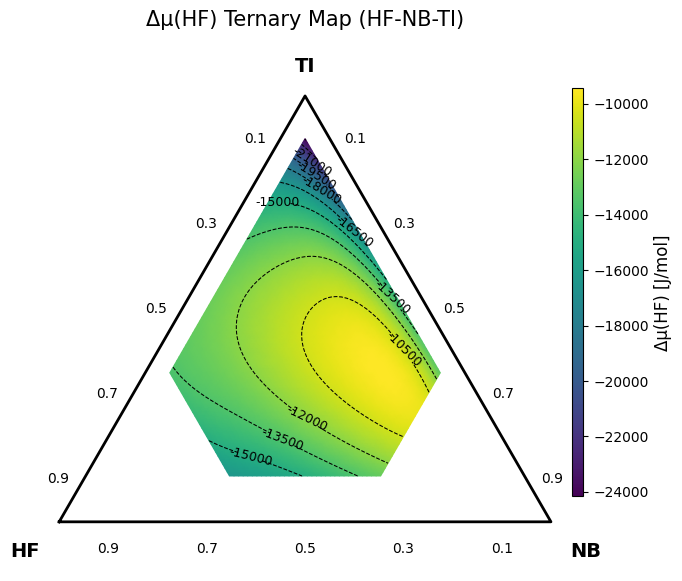

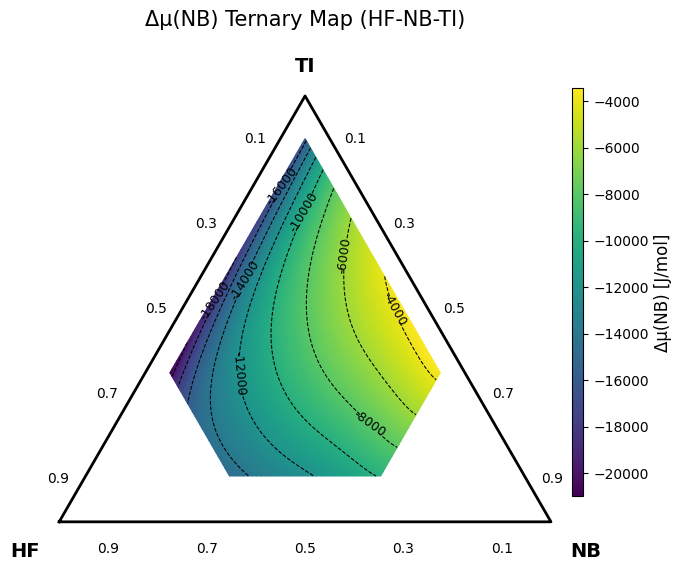

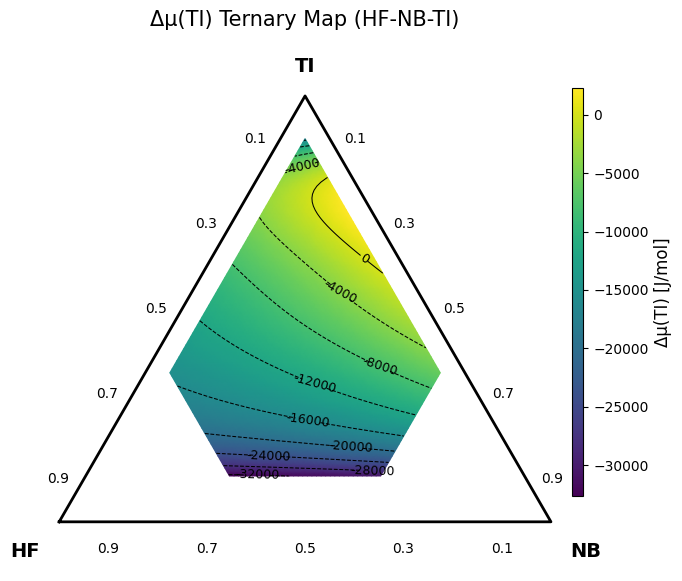

In [37]:
comps, comps_all, df_vals = generate_comps_and_driving_force(models, transformer, fixed_v=0.1)


#print(comps_all)
#print(df_vals)

# Plot ternary driving force map
#plot_driving_force_ternary(comps, df_vals, element='HF')
plot_driving_force_with_matplotlib(comps, df_vals, element='HF')
plot_driving_force_with_matplotlib(comps, df_vals, element='NB')
plot_driving_force_with_matplotlib(comps, df_vals, element='TI')

# Phase-field Solver using 3D chemcial potential calculator
## $x_V$ is fixed at 0.1

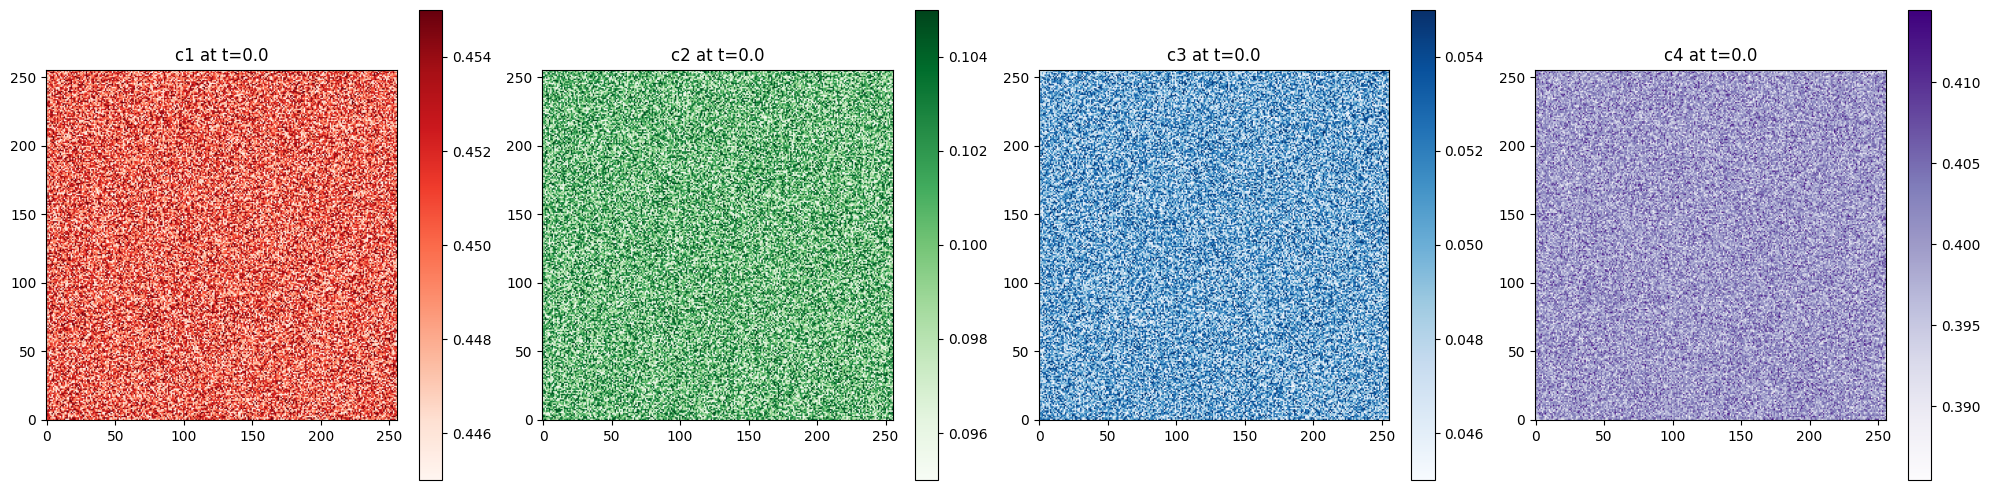

100%|████████████████████████████████████████████████████████████████████████████████████████████████████▋| 798/800 [00:25<00:00, 36.78it/s]

<Figure size 640x480 with 0 Axes>

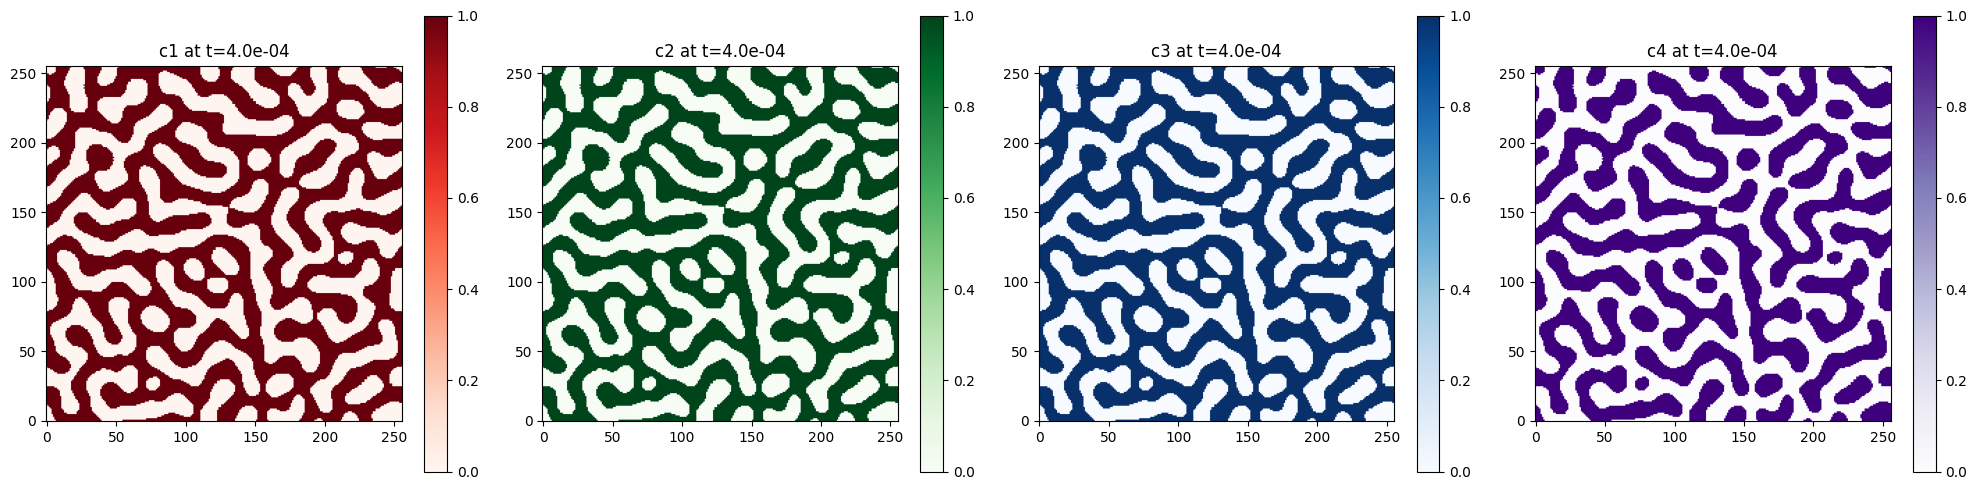

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:25<00:00, 30.82it/s]


In [31]:
# ==== Simulation Parameters ====
Kappa_c = 40.0e-19
M = 1.0
temp = 1000

# ==== Grid Setup ====
Lx = 100e-6
N = 256
h = Lx / (N - 1)
x = np.linspace(0, Lx, N)
y = x.copy()
xx, yy = np.meshgrid(x, y)

# ==== Spectral k-vectors ====
k = np.concatenate((np.arange(0, N//2), [0], np.arange(-N//2+1, 0)))
g = 2 * np.pi / Lx
kx = g * 1j * k
ky = g * 1j * k
kx, ky = np.meshgrid(kx, ky)
k2 = kx**2 + ky**2

# ==== Initial Conditions ====
np.random.seed(0)
c1 = 0.45 + 0.01 * (np.random.rand(N, N) - 0.5) # HF
c2 = 0.1 + 0.01 * (np.random.rand(N, N) - 0.5) # NB
c3 = 0.05 + 0.01 * (np.random.rand(N, N) - 0.5) # TI
c4 = 1.0 - c1 - c2 - c3

n = 0
plt.figure(figsize=(20, 5))
for idx, (c, label, cmap) in enumerate(zip([c1, c2, c3, c4], ['c1', 'c2', 'c3', 'c4'], ['Reds', 'Greens', 'Blues', 'Purples'])):
    plt.subplot(1, 4, idx+1)
    plt.imshow(c, cmap=cmap, origin='lower')
    plt.title(f'{label} at t={n*dt:.1f}')
    plt.colorbar()
    plt.tight_layout()

plt.show()
plt.savefig(f'microstructure-quaternary-real/quaternary_frame_{n}.jpg')


# ==== Time Setup ====
dt = 0.05e-5
tmax = 40e-5
max_iter = int(tmax / dt)
plot_indices = np.linspace(0, max_iter, 20, dtype=int)

# ==== Output Directory ====
if os.path.exists("microstructure-quaternary-real"):
    os.system("rm -r microstructure-quaternary-real")
os.makedirs("microstructure-quaternary-real", exist_ok=True)

# PyCalphad Direct Call (slow)
#G, dG_dx_HF_option1, dG_dx_NB_option1, dG_dx_TI_option1 = get_chemical_potential_nd(c1, c2, c3, temp=temp)
#print(G, dG_dx_HF_option1, dG_dx_NB_option1, dG_dx_TI_option1) 
#pause


# ==== Simulation Loop ====
for n in tqdm(range(1, max_iter + 1)):
    #print('iter ',n)
    c4 = 1.0 - c1 - c2 - c3

    # PyCalphad Direct Call (slow)
    #G, mu1, mu2, mu3 = get_chemical_potential_nd(c1, c2, c3, temp)

    # Polynomial fit call (fast)
    # Flatten and stack the compositions
    X_input = np.stack([c1.ravel(), c2.ravel(), c3.ravel()], axis=-1)
    
    # Transform for polynomial model
    X_poly = transformer.transform(X_input)
    
    # Predict and reshape back to 2D
    mu1 = models['HF'].predict(X_poly).reshape(N, N)
    mu2 = models['NB'].predict(X_poly).reshape(N, N)
    mu3 = models['TI'].predict(X_poly).reshape(N, N)

    mu1_hat = fft2(mu1)
    mu2_hat = fft2(mu2)
    mu3_hat = fft2(mu3)

    c1_hat = fft2(c1)
    c2_hat = fft2(c2)
    c3_hat = fft2(c3)

    denom = 1 + 2 * M * Kappa_c * dt * k2**2

    c1 = np.real(ifft2((c1_hat + M * dt * k2 * mu1_hat) / denom))
    c2 = np.real(ifft2((c2_hat + M * dt * k2 * mu2_hat) / denom))
    c3 = np.real(ifft2((c3_hat + M * dt * k2 * mu3_hat) / denom))
    c4 = 1.0 - c1 - c2 - c3

    # Clip to physical range
    c1 = np.clip(c1, 0.0, 1.0)
    c2 = np.clip(c2, 0.0, 1.0)
    c3 = np.clip(c3, 0.0, 1.0)
    c4 = np.clip(c4, 0.0, 1.0)

    if n == 1 or n in plot_indices or n == max_iter:
        plt.figure(figsize=(20, 5))
        for idx, (c, label, cmap) in enumerate(zip([c1, c2, c3, c4], ['c1', 'c2', 'c3', 'c4'], ['Reds', 'Greens', 'Blues', 'Purples'])):
            plt.subplot(1, 4, idx+1)
            plt.imshow(c, cmap=cmap, origin='lower')
            plt.title(f'{label} at t={n*dt:.1e}')
            plt.colorbar()
        plt.tight_layout()
        plt.savefig(f'microstructure-quaternary-real/quaternary_frame_{n}.jpg')
        if n == max_iter:
            plt.show()
        plt.close()